***
*Project:* Helmholtz Machine

*Author:* Jingwei Liu, Computer Music Ph.D., UC San Diego
***

# <span style="background-color:darkorange; color:white; padding:2px 6px">Function Test</span> 

# Helmholtz Machine MNIST


*Created:* March 13, 2025


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
torch.cuda.is_available()

True

In [2]:
def para_init(n_dz,dev):
    """
    Arguments:
    n_dz -- torch tensor of size len(n_dz)
    init_type -- "zero"

    Returns:
    Phi, Theta -- set of parameters for hierarchical layers
    """
    Phi = {}
    Theta = {}
    l = len(n_dz)
    for i in range(l-2):
        Phi["Phi_" + str(i) + str(i+1)] = torch.zeros((n_dz[i+1],n_dz[i]),device=dev)
    for i in range(l-1,0,-1):
        Theta["Theta_" + str(i) + str(i-1)] = torch.zeros((n_dz[i-1],n_dz[i]),device=dev)
    return Phi,Theta

In [3]:
def sigmoid(x):
    """
    Arguments:
    x -- torch tensor of shape (n,batch_size)
    
    Returns:
    p -- probability of layer y, torch tensor of shape (n,batch_size)
    """
    p = 1/(1+torch.exp(-x))
    return p

In [4]:
def one_step_forward(x,param):
    """
    Arguments:
    x -- input layer, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    
    Returns:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    """
    q = sigmoid(torch.matmul(param,x.type(torch.float)))
    return q

In [5]:
def sample(q,dev):
    """
    Arguments:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    dev -- device
    
    Returns:
    y -- instantiation of layer y, torch tensor of shape (n_y,batch_size)
    """
    y = (q > torch.rand(q.size(),device=dev)).long() # rejection sampling
    return y

In [6]:
def log(p):
    q = torch.where(p != 0, torch.log(p), -20) # replace log(0) with -100
    return q

In [7]:
def cross_entropy_loss(y,q):
    """
    Arguments:
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    
    Returns:
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    """
    loss = -(y * log(q) + (1-y) * log(1-q)).mean()
    return loss

In [8]:
def one_step_update(x,y,param,lr):
    """
    Arguments:
    x -- input layer sample, torch tensor of shape (n_x,batch_size)
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    lr -- learning rate
    
    Returns:
    grad -- gradient of parameters. Torch tensor of shape (n_y,n_x)
    param -- updated parameters from x to y. Torch tensor of shape (n_y,n_x)
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    """
    batch_size = x.shape[1]
    q = one_step_forward(x,param)
    grad = torch.matmul(q-y,torch.t(x.type(torch.float)))/batch_size # weight by precision
    param = param - lr*grad
    loss = cross_entropy_loss(y,q)
    return param, grad, loss

In [9]:
def layer_wise_train(input_x,param_xy,param_yx,lr,perturb):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param_xy -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    param_yx -- parameters from y to x. Torch tensor of shape (n_x,n_y)
    lr -- learning rate
    perturb -- With probability 1/4 the sampled value is flipped. Boolean value True or False.
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param_yx -- updated parameters from y to x
    grad -- gradient of param_yx. Torch tensor of shape (n_x,n_y)
    loss -- cross entropy loss at layer x
    """
    # Compute output layer distribution
    q = one_step_forward(input_x,param_xy)
    
    # Sample the output layer
    output_y = sample(q,dev)
    if perturb == True:
        output_y = (output_y + (torch.rand(output_y.size(),device=dev) < 1/4).long()).fmod(2)
    
    # train the opposite phase from x to y
    param_yx, grad, loss = one_step_update(output_y,input_x,param_yx,lr)
    
    return output_y, param_yx, grad, loss

In [10]:
def wake_phase(Phi,Theta,data,lr,dev,perturb):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,batch_size)
    lr -- learning rate
    dev -- torch device
    perturb -- With probability 1/4 the sampled value is flipped. Boolean value True or False.
    
    Returns:
    Theta -- updated sleep phase parameters.
    Grad -- set of gradients for Theta. len(Grad) = n_layer-1
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    input_x = data
    for i in range(n_layer-2):
        output_y, Theta["Theta_" + str(i+1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr,perturb)
        input_x = output_y
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Grad, Loss[n_layer-2] = \
    one_step_update(torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Loss

In [11]:
def wake_sample(Phi,data,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    data -- input data. Torch tensor of shape (n_d,batch_size)
    dev -- torch device
    
    Returns:
    Recog_sample -- set of bottom-up samples for hierarchical layers. len(Recog_sample) = n_layer-2. For every layer, 
    """
    n_layer = len(Phi) + 2
    batch_size = data.shape[1]
    input_x = data
    Recog_sample = {}
    Recog_sample["Layer_" + str(0)] = data
    for i in range(n_layer-2):
        input_x = sample(one_step_forward(input_x,Phi["Phi_" + str(i) + str(i+1)]),dev)
        Recog_sample["Layer_" + str(i+1)] = input_x
    return Recog_sample

In [12]:
def wake_phase_update(Phi,Theta,data,lr,dev,T,Eta):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,)
    lr -- learning rate
    dev -- torch device
    T -- cached layer-wise factorial distributions, len(R_ct) = n_layer-2
    Eta -- hyperparameter eta = eps/(1-eps). Torch tensor of shape (n_layer-2,)
    
    Returns:
    Theta -- updated sleep phase parameters.
    Grad -- set of gradients for Theta. len(Grad) = n_layer-1
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    input_x = data
    for i in range(n_layer-2):
        output_y, Theta["Theta_" + str(i+1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr,perturb=False)
        
        # update cached items
        T['Layer'+str(i+1)] = (T['Layer'+str(i+1)] + output_y.reshape(-1,)*Eta[i])/(1+Eta[i])
        input_x = output_y
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Grad, Loss[n_layer-2] = \
    one_step_update(torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Loss, T

In [13]:
def sleep_phase(Phi,Theta,gen_batch_size,lr,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Phi -- updated sleep phase parameters.
    Grad -- set of gradients for Phi. len(Grad) = n_layer-2
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    unit = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    input_x = sample(one_step_forward(unit,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)]),dev)
    for i in range(n_layer-2,0,-1):
        output_y, Phi["Phi_" + str(i-1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Theta["Theta_" + str(i) + str(i-1)],Phi["Phi_" + str(i-1) + str(i)],lr,perturb=False)
        input_x = output_y
    return Phi, Loss

In [14]:
def sleep_sample(Theta,gen_batch_size,dev):
    """
    Arguments:
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    dev -- torch device
    
    Returns:
    Gen_sample -- set of top-down generations for hierarchical layers. len(Gen_sample) = n_layer-1. For every layer, 
                    gen_sample is of shape (n_y, gen_batch_size)
    """
    n_layer = len(Theta) + 1
    input_x = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    Gen_sample = {}
    for i in range(n_layer-1,0,-1):
        input_x = sample(one_step_forward(input_x,Theta["Theta_" + str(i) + str(i-1)]),dev)
        Gen_sample["Layer_" + str(i-1)] = input_x
    return Gen_sample

In [15]:
def sleep_phase_update(Phi,Theta,lr,dev,T,Eta):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    lr -- learning rate
    dev -- torch device
    T -- cached layer-wise factorial distributions, len(R_ct) = n_layer-2
    Eta -- hyperparameter eta = eps/(1-eps). Torch tensor of shape (n_layer-2,)
    
    Returns:
    Theta -- updated sleep phase parameters.
    Grad -- set of gradients for Theta. len(Grad) = n_layer-1
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    unit = torch.ones(1,1,dtype=int,device=dev)
    input_x = sample(one_step_forward(unit,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)]),dev)
    for i in range(n_layer-2,0,-1):
        output_y, Phi["Phi_" + str(i-1) + str(i)], Grad, Loss[i] = \
        layer_wise_train(input_x,Theta["Theta_" + str(i) + str(i-1)],Phi["Phi_" + str(i-1) + str(i)],lr)
        input_x = output_y
        # update cached items
        T['Layer'+str(i-1)] = (T['Layer'+str(i-1)] + output_y.reshape(-1,)*Eta[i-1])/(1+Eta[i-1])
    return Phi, Loss, T

In [16]:
def decimalize(bnr,dev):
    """
    Arguments: bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    Returns: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    """
    width = bnr.shape[0]
    n = bnr.shape[1]
    dcm = torch.zeros(n,dtype=int,device=dev)
    bnr = bnr.to('cpu').numpy()
    for i in range(n):
        binary = ''.join(bnr[:,i].reshape(width,).astype(str))
        dcm[i] = int(binary,2)
    return dcm

In [17]:
def decimalize_np(bnr):
    """
    Arguments: bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    Returns: dcm -- a decimalized intger numpy array in range [0,2**width), shape (n,)
    """
    width = bnr.shape[0]
    n = bnr.shape[1]
    dcm = np.zeros(n,dtype=int)
    bnr = bnr.to('cpu').numpy()
    for i in range(n):
        binary = ''.join(bnr[:,i].reshape(width,).astype(str))
        dcm[i] = int(binary,2)
    return dcm

In [18]:
def binarilize(dcm,width,dev):
    """
    Arguments: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    Returns:   bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    """
    n = len(dcm)
    bnr = np.zeros((width,n),dtype=int)
    for i in range(n):
        bnr[:,i:i+1] = np.array(list(np.binary_repr(dcm[i], width=width))).astype(int).reshape(-1,1)
    bnr = torch.from_numpy(bnr).type(torch.int64).to(dev)
    return bnr

In [19]:
def one_step_prob_matrix(n_x, param,dev):
    """
    Arguments:
    n_x -- number of neurons at input layer x
    param -- parameters from layer x to y. Torch tensor of shape (n_y,n_x)
    dev -- torch device
    
    Returns:
    prob_ft -- factorial probability. Torch tensor of shape (2**n_x, n_y).
    prob_ct -- categorical probability. Torch tensor of shape (2**n_x, 2**n_y)
    """
    X = binarilize(np.arange(2**n_x),n_x,dev)  # (n_x,2**n_x)
    q = one_step_forward(X,param)   # (n_y,2**n_x)
    prob_ft = torch.t(q)  # (2**n_x,n_y)
    
    # categorical probability
    n_y = q.shape[0]
    Y = binarilize(np.arange(2**n_y),n_y,dev)  # (n_y,2**n_y)
    prob_ct = torch.zeros(2**n_x, 2**n_y,device=dev)
    for i in range(2**n_x):
        prob_ct[i,:] = torch.prod(q[:,i:i+1]**Y * (1-q[:,i:i+1])**(1-Y),axis=0)
    
    # Ursatz = 1
    if n_x == 1:
        prob_ft = prob_ft[1:,:]
        prob_ct = prob_ct[1:,:]
    return prob_ft, prob_ct

\begin{equation}
    p_j^{+1}(\mathrm{y}_j) = \sigma\Big(\sum_{i=1}^n \mathrm{w}_{ij} \mathrm{x}_i - \sum_{i=1}^n\mathrm{x}_i^2 \cdot \gamma \big(p_j - \mathrm{y}_j\big)\Big)
\end{equation}
Linear approximation:
\begin{equation}
    p_j^{+1}(\mathrm{y}_j) = p_j - \epsilon (p_j - \mathrm{y}_j)
\end{equation}

In [20]:
def increment(input_x, param, lr,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param -- parameters from layer x to y. Torch tensor of shape (n_y,n_x)
    lr -- learning rate
    dev -- torch device
    
    Returns:
    eps -- Estimated hyperparameter epsilon
    """
    linear = torch.matmul(param,input_x.type(torch.float)) # (n_y,batch_size)
    p = sigmoid(linear) # (n_y,batch_size)
    linear_update_0 = linear - input_x.sum(axis=0,keepdim=True)*lr*p
    linear_update_1 = linear - input_x.sum(axis=0,keepdim=True)*lr*(p-1)
    p_add_0 = sigmoid(linear_update_0)
    p_add_1 = sigmoid(linear_update_1)
    eps0 = (p - p_add_0)/(p+1e-8)  # (n_y,batch_size)
    eps1 = (p - p_add_1)/(p-1+1e-8)
    eps = (eps0 + eps1)/2
#     print(eps0,eps1)
    eps = eps.mean()
    return eps

In [21]:
def entropy(row_dist):
    """
    Arguments: row_dist -- unnormalized row distribution. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H -- row entropy. Torch tensor of shape (n_row,1) or a number
    """
    if row_dist.ndim == 1:
        p = row_dist/row_dist.sum()
        H = (-p * log(p)).sum()
    else:
        P = row_dist/row_dist.sum(axis=1,keepdims=True)
        H = (-P * log(P)).sum(axis=1,keepdims=True)
    return H

In [22]:
def entropy_bernoulli(P_ber):
    """
    Arguments: P_ber -- multi-variate independent row Bernoulli distributions. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H_ber -- row Bernoulli entropy. Torch tensor of shape (n_row,1) or a number
    """
    entropy = - (P_ber * log(P_ber) + (1-P_ber) * log(1-P_ber))
    if P_ber.ndim == 1:
        H_ber = entropy.sum()
    else:
        H_ber = entropy.sum(axis=1,keepdims=True)
    return H_ber

In [23]:
def KL_divergence(p,q):
    """
    Arguments: probability distribution p,q. Torch tensors of shape (n,)
    Returns: KL-divergence (p*log(p/q)).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL = (p*log(p) - p*log(q)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL

In [24]:
def KL_divergence_inclusive(p,q):
    """
    Arguments: probability distribution p,q. Torch tensors of shape (n,)
    Returns: KL-divergence (p*log(p/q)).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL = (p*log(p) - p*torch.where(q != 0, torch.log(q), 0)).sum() # q=0, log(q)=0
    else:
        raise Exception('Dimension error')
    return D_KL

In [25]:
def KL_divergence_bernoulli(p,q):
    """
    Arguments: multi-variate independent Bernoulli distributions. Torch tensors of shape (n,)
    Returns: sum of n bernoulli variable KL-divergence (p*log(p/q)+(1-p)*log((1-p)/(1-q))).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL_bernoulli = (p*log(p) - p*log(q) + (1-p)*log(1-p) - (1-p)*log(1-q)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL_bernoulli

In [26]:
def one_step_prob_entropy(q):
    """
    Arguments:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    
    Returns:
    p_y -- Bernoulli probability of each neuron at layer Y. Torch tensor of shape (n_y,)
    H_Y -- factorial entropy at output layer Y, a tensor number
    I -- mutual information between layers X and Y, a tensor number
    """
    p_yx = q.t()   # (batch_size,n_y)
    H_YX = entropy_bernoulli(p_yx).mean() # tensor number
    p_y = p_yx.mean(axis=0) # (n_y,)
    H_Y = entropy_bernoulli(p_y) # tensor number
    I = H_Y - H_YX
    return H_Y, I

In [27]:
def wake_entropy(Phi,data,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    data -- input data. Torch tensor of shape (n_d,batch_size)
    dev -- torch device
    
    Returns:
    H_Y_wake -- factorial entropy at layers 1,...,n_layer-2. Torch tensor of shape (n_layer-2,)
    I_wake -- mutual information between layers [0,1],...,[n_layer-3,n_layer-2]. Torch tensor of shape (n_layer-2,)
    """
    n_layer = len(Phi) + 2
    H_Y_wake = torch.zeros(n_layer-2)
    I_wake = torch.zeros(n_layer-2)
    input_x = data
    for i in range(n_layer-2):
        q = one_step_forward(input_x,Phi["Phi_" + str(i) + str(i+1)])
        H_Y_wake[i], I_wake[i] = one_step_prob_entropy(q)
        input_x = sample(q,dev)
    return H_Y_wake, I_wake

In [28]:
def sleep_entropy(Theta,gen_batch_size,dev):
    """
    Arguments:
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    dev -- torch device
    
    Returns:
    H_Y_sleep -- factorial entropy at layers 0,...,n_layer-2. Torch tensor of shape (n_layer-2,)
    I_sleep -- mutual information between layers [1,0],...,[n_layer-2,n_layer-3]. Torch tensor of shape (n_layer-2,)
    """
    n_layer = len(Theta) + 1
    H_Y_sleep = torch.zeros(n_layer-1)
    I_sleep = torch.zeros(n_layer-1)
    input_x = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    for i in range(n_layer-1,0,-1):
        q = one_step_forward(input_x,Theta["Theta_" + str(i) + str(i-1)])
        H_Y_sleep[i-1], I_sleep[i-1] = one_step_prob_entropy(q)
        input_x = sample(q,dev)
    I_sleep = I_sleep[:-1]
    return H_Y_sleep, I_sleep

### 1. $H(Y|x)$

\begin{equation}
    p_j^{+1}(\mathrm{y}_j) = p_j - \epsilon (p_j - \mathrm{y}_j) = (1-\epsilon) p_j + \epsilon \mathrm{y}_j,  \qquad \mathrm{y}_j = \{0,1\}
\end{equation}

In [29]:
def conditional_entropy(x,param,eps,dev):
    """
    Arguments:
    x -- input layer, torch tensor of shape (n_x,)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    eps -- epsilon, hyperparameter of O(lr)
    dev -- device
    
    Returns:
    H_Yx -- conditional entropy H_Yx at output layer Y, torch tensor of shape (2, n_y)
    """
    q = one_step_forward(x,param).reshape(-1,) # (n_y,)
    n_y = len(q)
    q_add = torch.zeros(2,n_y,device=dev) # p_j+1 of y_j = 0 (row1) and y_j = 1 (row2)
    q_add[0,:] = (1-eps) * q
    q_add[1,:] = (1-eps) * q + eps
    H_Yx = -(q_add*log(q_add) + (1-q_add)*log(1-q_add)) # (2,n_y)
    return H_Yx

### 2. $H(Y)_{ft}$

\begin{equation}
\mathbf{t} = \begin{pmatrix}
   \mathrm{p_1};&  \mathrm{p_2};&  \ldots;&  \mathrm{p_m}
    \end{pmatrix} 
\end{equation}
$\mathrm{p_j}$'s are Bernoulli probabilities.

\begin{equation}
    \mathrm{p_j}^{+1}(\mathrm{y}_j) = \left \{
    \begin{array}{ll}
     \frac{\mathrm{p_j} + \eta}{1+\eta},  &  \text{if } \mathrm{y}_j = 1\\
     \frac{\mathrm{p_j}}{1+\eta},   & \text{if } \mathrm{y}_j = 0
    \end{array}
    \right. \label{epsilon modify}
\end{equation}

In [30]:
def factorial_entropy(t,eta,dev):
    """
    Arguments:
    t -- Multi-variate Bernoulli distribution (p_1;p_2;...p_{n_y}), torch tensor of shape (n_y,)
    eta -- eta, hyperparameter of eta = eps/(1-eps)
    dev -- device
    
    Returns:
    H_ft -- factorial entropy H_ft at output layer Y, torch tensor of shape (2,n_y)
    """
    n_y = len(t)
    p_add = torch.zeros(2,n_y,device=dev) # p+1 of y_j = 0 (row1) and y_j = 1 (row2)
    p_add[0,:] = t/(1+eta)
    p_add[1,:] = (t+eta)/(1+eta)
    H_ft = -(p_add*log(p_add) + (1-p_add)*log(1-p_add)) # (2,n_y)
    return H_ft

In [31]:
def MI_max(I):
    """
    Argument: I -- mutual information, torch tensor of shape (2,n_y)
    Return: index -- sampled index, torch tensor of shape (n_y,)
    """
    index = I.argmax(dim=0)
    return index

In [32]:
def MI_train(input_x,param_xy,param_yx,lr,H_Y,eps,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,1)
    param_xy -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    param_yx -- parameters from y to x. Torch tensor of shape (n_x,n_y)
    lr -- learning rate
    H_Y -- entropy H(Y). Comnination of H_ct_state and H_ft_state
    eps -- epsilon, hyperparameter of O(lr)
    dev -- device
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    param_yx -- updated parameters from y to x
    grad -- gradient of param_yx. Torch tensor of shape (n_x,n_y)
    loss -- cross entropy loss at layer x
    """
    # H_Yx
    H_Yx = conditional_entropy(input_x,param_xy,eps,dev) # (2**n_y,)

    # Compute mutual information
    I = H_Y - H_Yx
   
    # Maximum I
    output_y = MI_max(I).reshape(-1,1)  # (n_y,1)
    
    # train the opposite phase from x to y
    param_yx, grad, loss = one_step_update(output_y,input_x,param_yx,lr)
    
    return I, output_y, param_yx, grad, loss

In [33]:
def wake_phase_MI(Phi,Theta,data,lr,T,Epsilon,Eta,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,batch_size)
    lr -- learning rate
    T -- cached layer-wise factorial distributions, len(R_ct) = n_layer-2
    Epsilon -- hyperparameter of O(lr). Torch tensor of shape (n_layer-2,)
    Eta -- hyperparameter eta = eps/(1-eps). Torch tensor of shape (n_layer-2,)
    dev -- torch device
    
    Returns:
    Theta -- updated sleep phase parameters.
    Grad -- set of gradients for Theta. len(Grad) = n_layer-1
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    input_x = data
    for i in range(n_layer-2):
        # H_ft
        H_Y = factorial_entropy(T['Layer'+str(i+1)],Eta[i],dev)

        # layer-wise training
        I, output_y, Theta["Theta_" + str(i+1) + str(i)], Grad, Loss[i] = \
        MI_train(input_x,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr,H_Y,Epsilon[i],dev)
        
        # update cached items
        T['Layer'+str(i+1)] = (T['Layer'+str(i+1)] + output_y.reshape(-1,)*Eta[i])/(1+Eta[i])
        input_x = output_y
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Grad, Loss[n_layer-2] = \
    one_step_update(torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Loss, T

In [34]:
def initialize_MI(data,Phi,lr,dev):
    """
    Arguments:
    data -- input dataset, torch tensor of shape (n_d, batch_size)
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    lr -- learning rate
    dev -- torch device
    
    Returns:
    T -- cached layer-wise factorial distributions, len(R_ct) = n_layer-2
    Epsilon -- hyperparameter of O(lr). Torch tensor of shape (n_layer-2,)
    Eta -- hyperparameter eta = eps/(1-eps). Torch tensor of shape (n_layer-2,)
    Delta -- hyperparameter O(eta/2^(m-1)), torch tensor of shape (n_layer-2,)
    """
    T = {}
    Epsilon = torch.zeros(n_layer-2,device=dev)
    batch_size = data.shape[1]
    Recog_sample = wake_sample(Phi,data,dev)
    for i in range(n_layer-2):
        input_x = Recog_sample["Layer_" + str(i)]  #(n_x, batch_size)
        Epsilon[i] = increment(input_x, Phi["Phi_" + str(i) + str(i+1)], lr,dev)
        
        y_sample = Recog_sample["Layer_" + str(i+1)] #(n_y, batch_size)
        T['Layer'+str(i+1)] = y_sample.sum(axis=1)/batch_size
        
    Eta = Epsilon/(1-Epsilon) # H_ft; eta = eps/(1-eps)
    return T,Epsilon,Eta

## MNIST Data "0"

- $28 \times 28$ images of handwritten "0".

In [35]:
from torchvision import datasets, transforms

In [36]:
dev = torch.device("cuda") # operate on GPU "cuda" or CPU "cpu"

In [37]:
# Define the transformation to convert images to PyTorch tensors
transform = transforms.Compose([transforms.ToTensor(),transforms.Lambda(lambda x: x.to(dev))])
# Load the MNIST dataset with the specified transformation
mnist_pytorch = datasets.MNIST(root='D:\deep music\MNIST', train=True, download=False, transform=transform)
mnist_pytorch

Dataset MNIST
    Number of datapoints: 60000
    Root location: D:\deep music\MNIST
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Lambda()
           )

In [38]:
train_loader_pytorch = torch.utils.data.DataLoader(mnist_pytorch, batch_size=60000, shuffle=False)

In [39]:
for i, (image, label) in enumerate(train_loader_pytorch):
    if i > 0:
        break

In [40]:
image.shape

torch.Size([60000, 1, 28, 28])

In [41]:
image.squeeze().shape

torch.Size([60000, 28, 28])

In [42]:
image_binary = (image.squeeze()>0.5).long()
image_binary.shape

torch.Size([60000, 28, 28])

In [43]:
# torch.save(image_binary, "MNIST_binary.pt")

In [44]:
image_binary = torch.load('D:\deep music\MNIST\MNIST\MNIST_binary.pt')
image_binary.shape

C:\Users\79244\AppData\Local\Temp\ipykernel_26304\3629808137.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_binary = torch.load('D:\deep music\MNIST\MNIST\MNIST_b

torch.Size([60000, 28, 28])

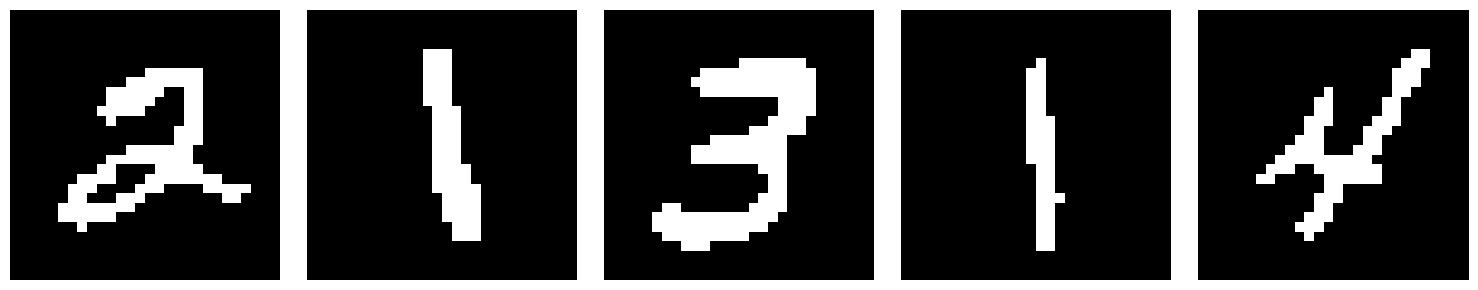

In [45]:
# Create a figure to display the images
plt.figure(figsize=(15, 3))

# Print the first few images in a row
for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(image_binary[i+5,:,:].to('cpu').numpy(), cmap='gray')
#         plt.imshow(image.squeeze()[i+300,:,:].to('cpu').numpy(), cmap='gray')
#         plt.title(f"Label: {label[i+5].item()}")
        plt.axis('off')
plt.tight_layout()
plt.show()

In [46]:
data = image_binary.reshape(-1,784).t()
data.shape

torch.Size([784, 60000])

## Model

In [43]:
structure = [784,735,686,637,588,539,490,441,392,343,294,245,196,147,98,49,25,10,1] #19
n_dz = torch.tensor(structure)
n_dz

tensor([784, 735, 686, 637, 588, 539, 490, 441, 392, 343, 294, 245, 196, 147,
         98,  49,  25,  10,   1])

In [44]:
n_layer = len(n_dz)
n_layer

19

In [45]:
n_d = n_dz[0]
n_d

tensor(784)

In [50]:
col_list = []
for i in range(1,n_layer-1):
    col_list.append('Phi_Loss_Layer_'+str(i))
for i in range(n_layer-1):
    col_list.append('Theta_Loss_Layer_'+str(i))
for i in range(1,n_layer-1):
    col_list.append('Recog_H_Layer_'+str(i))
for i in range(1,n_layer-1):
    col_list.append('Recog_I_Layer_'+str(i))
for i in range(n_layer-1):
    col_list.append('Gen_H_Layer_'+str(i))
for i in range(1,n_layer-1):
    col_list.append('Gen_I_Layer_'+str(i))
col_list

['Phi_Loss_Layer_1',
 'Phi_Loss_Layer_2',
 'Phi_Loss_Layer_3',
 'Phi_Loss_Layer_4',
 'Phi_Loss_Layer_5',
 'Phi_Loss_Layer_6',
 'Phi_Loss_Layer_7',
 'Phi_Loss_Layer_8',
 'Phi_Loss_Layer_9',
 'Phi_Loss_Layer_10',
 'Phi_Loss_Layer_11',
 'Phi_Loss_Layer_12',
 'Phi_Loss_Layer_13',
 'Phi_Loss_Layer_14',
 'Phi_Loss_Layer_15',
 'Phi_Loss_Layer_16',
 'Phi_Loss_Layer_17',
 'Theta_Loss_Layer_0',
 'Theta_Loss_Layer_1',
 'Theta_Loss_Layer_2',
 'Theta_Loss_Layer_3',
 'Theta_Loss_Layer_4',
 'Theta_Loss_Layer_5',
 'Theta_Loss_Layer_6',
 'Theta_Loss_Layer_7',
 'Theta_Loss_Layer_8',
 'Theta_Loss_Layer_9',
 'Theta_Loss_Layer_10',
 'Theta_Loss_Layer_11',
 'Theta_Loss_Layer_12',
 'Theta_Loss_Layer_13',
 'Theta_Loss_Layer_14',
 'Theta_Loss_Layer_15',
 'Theta_Loss_Layer_16',
 'Theta_Loss_Layer_17',
 'Recog_H_Layer_1',
 'Recog_H_Layer_2',
 'Recog_H_Layer_3',
 'Recog_H_Layer_4',
 'Recog_H_Layer_5',
 'Recog_H_Layer_6',
 'Recog_H_Layer_7',
 'Recog_H_Layer_8',
 'Recog_H_Layer_9',
 'Recog_H_Layer_10',
 'Recog_H_La

In [51]:
len(col_list)

104

In [52]:
Analytic_MNIST_new = pd.DataFrame(columns=col_list)
Analytic_MNIST_new

Empty DataFrame
Columns: [Phi_Loss_Layer_1, Phi_Loss_Layer_2, Phi_Loss_Layer_3, Phi_Loss_Layer_4, Phi_Loss_Layer_5, Phi_Loss_Layer_6, Phi_Loss_Layer_7, Phi_Loss_Layer_8, Phi_Loss_Layer_9, Phi_Loss_Layer_10, Phi_Loss_Layer_11, Phi_Loss_Layer_12, Phi_Loss_Layer_13, Phi_Loss_Layer_14, Phi_Loss_Layer_15, Phi_Loss_Layer_16, Phi_Loss_Layer_17, Theta_Loss_Layer_0, Theta_Loss_Layer_1, Theta_Loss_Layer_2, Theta_Loss_Layer_3, Theta_Loss_Layer_4, Theta_Loss_Layer_5, Theta_Loss_Layer_6, Theta_Loss_Layer_7, Theta_Loss_Layer_8, Theta_Loss_Layer_9, Theta_Loss_Layer_10, Theta_Loss_Layer_11, Theta_Loss_Layer_12, Theta_Loss_Layer_13, Theta_Loss_Layer_14, Theta_Loss_Layer_15, Theta_Loss_Layer_16, Theta_Loss_Layer_17, Recog_H_Layer_1, Recog_H_Layer_2, Recog_H_Layer_3, Recog_H_Layer_4, Recog_H_Layer_5, Recog_H_Layer_6, Recog_H_Layer_7, Recog_H_Layer_8, Recog_H_Layer_9, Recog_H_Layer_10, Recog_H_Layer_11, Recog_H_Layer_12, Recog_H_Layer_13, Recog_H_Layer_14, Recog_H_Layer_15, Recog_H_Layer_16, Recog_H_Layer_17, Recog_I_Layer_1, Recog_I_Layer_2, Recog_I_Layer_3, Recog_I_Layer_4, Recog_I_Layer_5, Recog_I_Layer_6, Recog_I_Layer_7, Recog_I_Layer_8, Recog_I_Layer_9, Recog_I_Layer_10, Recog_I_Layer_11, Recog_I_Layer_12, Recog_I_Layer_13, Recog_I_Layer_14, Recog_I_Layer_15, Recog_I_Layer_16, Recog_I_Layer_17, Gen_H_Layer_0, Gen_H_Layer_1, Gen_H_Layer_2, Gen_H_Layer_3, Gen_H_Layer_4, Gen_H_Layer_5, Gen_H_Layer_6, Gen_H_Layer_7, Gen_H_Layer_8, Gen_H_Layer_9, Gen_H_Layer_10, Gen_H_Layer_11, Gen_H_Layer_12, Gen_H_Layer_13, Gen_H_Layer_14, Gen_H_Layer_15, Gen_H_Layer_16, Gen_H_Layer_17, Gen_I_Layer_1, Gen_I_Layer_2, Gen_I_Layer_3, Gen_I_Layer_4, Gen_I_Layer_5, Gen_I_Layer_6, Gen_I_Layer_7, Gen_I_Layer_8, Gen_I_Layer_9, Gen_I_Layer_10, Gen_I_Layer_11, Gen_I_Layer_12, Gen_I_Layer_13, ...]
Index: []

[0 rows x 104 columns]

In [53]:
Phi,Theta = para_init(n_dz,dev)

### Training

In [37]:
para = torch.load('Parameters_MNIST_19', dev,weights_only=True)
Phi = para['Phi']
Theta = para['Theta']

In [38]:
Analytic_MNIST_19 = pd.read_csv('Analytic_MNIST_19.csv', sep=",")
Analytic_MNIST_19

Phi_Loss_Layer_1  Phi_Loss_Layer_2  Phi_Loss_Layer_3  Phi_Loss_Layer_4  \
0             0.693147          0.693147          0.693147          0.693147   
1             0.225164          0.041425          0.017908          0.029702   
2             0.146342          0.040348          0.017890          0.029893   
3             0.164549          0.039102          0.017987          0.029832   
4             0.150649          0.041085          0.018027          0.029913   
...                ...               ...               ...               ...   
7523          0.044693          0.000957          0.011253          0.008217   
7524          0.079888          0.000905          0.011288          0.008372   
7525          0.052317          0.000950          0.011276          0.008363   
7526          0.070439          0.000866          0.011280          0.008472   
7527          0.071448          0.000856          0.011158          0.008556   

      Phi_Loss_Layer_5  Phi_Loss_Layer_6  Phi_Loss_Layer_7  Phi_Loss_Layer_8  \
0             0.693147          0.693147          0.693147          0.693148   
1             0.045722          0.082702          0.166376          0.230180   
2             0.046003          0.085576          0.158673          0.182513   
3             0.046036          0.086367          0.151086          0.143090   
4             0.045986          0.088162          0.145993          0.181316   
...                ...               ...               ...               ...   
7523          0.009883          0.015478          0.025055          0.052131   
7524          0.009494          0.015547          0.025342          0.051851   
7525          0.009560          0.015554          0.025169          0.051429   
7526          0.009512          0.015535          0.025394          0.051317   
7527          0.009568          0.015587          0.025540          0.051378   

      Phi_Loss_Layer_9  Phi_Loss_Layer_10  ...  Gen_I_Layer_8  Gen_I_Layer_9  \
0             0.693148           0.693148  ...       0.000092       0.000061   
1             0.271340           0.425494  ...       0.042580       0.058922   
2             0.259556           0.409082  ...       0.031807       0.052689   
3             0.206983           0.316202  ...       0.023888       0.043350   
4             0.281700           0.484016  ...       0.029160       0.138405   
...                ...                ...  ...            ...            ...   
7523          0.054491           0.115636  ...       0.003386       0.011349   
7524          0.054605           0.113864  ...       0.003378       0.011335   
7525          0.054287           0.114794  ...       0.003328       0.011227   
7526          0.054669           0.111779  ...       0.003363       0.011320   
7527          0.055211           0.112351  ...       0.003385       0.011490   

      Gen_I_Layer_10  Gen_I_Layer_11  Gen_I_Layer_12  Gen_I_Layer_13  \
0           0.000076        0.000031        0.000031        0.000015   
1           0.168159        0.178528        0.013138        0.001877   
2           0.221016        0.177879        0.020508        0.003860   
3           0.226479        0.185066        0.052460        0.005981   
4           1.016319        0.148270        0.033463        0.008301   
...              ...             ...             ...             ...   
7523        0.025883        0.098564        0.110813        0.073650   
7524        0.025412        0.100586        0.116333        0.074417   
7525        0.025585        0.103542        0.120338        0.075703   
7526        0.024965        0.099648        0.118816        0.074635   
7527        0.025190        0.100685        0.120636        0.077114   

      Gen_I_Layer_14  Gen_I_Layer_15  Gen_I_Layer_16  Gen_I_Layer_17  
0           0.000008       -0.000008       -0.000004        0.000004  
1           0.000595        0.000137        0.000042        0.000006  
2           0.001015        0.000237        0

In [53]:
para = torch.load('Parameters_MNIST_19_large10', dev,weights_only=True)
Phi = para['Phi']
Theta = para['Theta']

In [54]:
Analytic_MNIST_19_large10 = pd.read_csv('Analytic_MNIST_19_large10.csv', sep=",")
Analytic_MNIST_19_large10

Phi_Loss_Layer_1  Phi_Loss_Layer_2  Phi_Loss_Layer_3  Phi_Loss_Layer_4  \
0            0.693147          0.693147          0.693147          0.693147   
1            0.370130          0.043661          0.017744          0.030447   
2            0.376050          0.040268          0.017673          0.030430   
3            0.403005          0.041707          0.017656          0.030479   
4            0.393797          0.042282          0.017676          0.030459   
..                ...               ...               ...               ...   
781          0.263124          0.007331          0.071354          0.020966   
782          0.190094          0.007422          0.070099          0.020971   
783          0.205750          0.007980          0.071061          0.020968   
784          0.148399          0.008171          0.070469          0.020937   
785          0.157513          0.008527          0.069891          0.021056   

     Phi_Loss_Layer_5  Phi_Loss_Layer_6  Phi_Loss_Layer_7  Phi_Loss_Layer_8  \
0            0.693147          0.693147          0.693147          0.693147   
1            0.048328          0.082483          0.161980          0.272955   
2            0.048401          0.082267          0.147758          0.260001   
3            0.048500          0.081767          0.119642          0.204970   
4            0.048611          0.080753          0.108508          0.178845   
..                ...               ...               ...               ...   
781          0.027864          0.008560          0.057139          0.094633   
782          0.027971          0.008555          0.057829          0.097773   
783          0.028000          0.008652          0.057486          0.100734   
784          0.027916          0.008664          0.057176          0.098427   
785          0.027986          0.008694          0.057359          0.098171   

     Phi_Loss_Layer_9  Phi_Loss_Layer_10  ...  Gen_I_Layer_8  Gen_I_Layer_9  \
0            0.693147           0.693147  ...       0.000000       0.000031   
1            0.086761           0.431514  ...       0.047142       0.017906   
2            0.384803           0.389442  ...       0.038597       0.099449   
3            0.232971           0.421692  ...       0.022251       0.043625   
4            0.189618           0.443052  ...       0.016594       0.030495   
..                ...                ...  ...            ...            ...   
781          0.134604           0.330190  ...       0.016233       0.030521   
782          0.132930           0.339743  ...       0.017076       0.032047   
783          0.130534           0.314095  ...       0.017244       0.031719   
784          0.136964           0.333437  ...       0.016405       0.032959   
785          0.143155           0.310568  ...       0.016506       0.033596   

     Gen_I_Layer_10  Gen_I_Layer_11  Gen_I_Layer_12  Gen_I_Layer_13  \
0         -0.000015        0.000015       -0.000031        0.000000   
1          0.044661        0.164146        0.017075        0.000458   
2          0.476212        0.197556        0.003555        0.000961   
3          0.226219        0.180672        0.006973        0.001205   
4          0.177345        0.173706        0.006973        0.001724   
..              ...             ...             ...             ...   
781        0.250240        0.486839        0.123062        0.035202   
782        0.262726        0.489014        0.138824        0.038086   
783        0.233807        0.412277        0.144897        0.036240   
784        0.264027        0.482727        0.140022        0.038254   
785        0.258522        0.423653        0.136429        0.035767   

     Gen_I_Layer_14  Gen_I_Layer_15  Gen_I_Layer_16  Gen_I_Layer_17  
0          0.000015       -0.000023       -0.000008        0.000006  
1          0.000069        0.000015        0.000000        0.000000  
2          0.000114        0.000031        0.000008        0.000002  
3          0.000183      

In [75]:
batch_size = 60000
gen_batch_size = 60000
lr = 0.1
epoch = 10
data.shape

torch.Size([784, 60000])

In [76]:
for e in range(epoch):
    Theta, Loss_sleep = wake_phase(Phi,Theta,data,lr,dev,perturb=False)
    Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
    print('Loss_wake:',Loss_wake,'    Loss_sleep:',Loss_sleep)
    if e % 50 == 0:
        stat = []
        stat = stat + list((Loss_wake[1:]).to('cpu').numpy())
        stat = stat + list((Loss_sleep).to('cpu').numpy())
        H_Y_wake, I_wake = wake_entropy(Phi,data,dev)
        H_Y_sleep, I_sleep = sleep_entropy(Theta,gen_batch_size,dev)
        stat = stat + list(H_Y_wake.to('cpu').numpy()) + list(I_wake.to('cpu').numpy()) \
                + list(H_Y_sleep.to('cpu').numpy()) + list(I_sleep.to('cpu').numpy())
        Analytic_MNIST_new.loc[len(Analytic_MNIST_new)] = stat
        
        parameters = {'Phi': Phi, 'Theta': Theta}
        torch.save(parameters,'Parameters_MNIST_new')
        Analytic_MNIST_new.to_csv('Analytic_MNIST_new.csv', index = False)

Loss_wake: tensor([0.0000, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931,
        0.6931])     Loss_sleep: tensor([0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931, 0.6931,
        0.6931])


KeyboardInterrupt: 

In [ ]:
# for e in range(epoch):
#     Loss_W = 0
#     Loss_S = 0
#     train_loader_pytorch = torch.utils.data.DataLoader(mnist_pytorch, batch_size=5000, shuffle=True)
#     for i, (image, label) in enumerate(train_loader_pytorch):
#         data = (image.squeeze()>0.5).long().reshape(-1,784).t()
#         Theta, Loss_sleep = wake_phase(Phi,Theta,data,lr,dev,perturb=False)
#         Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
#         Loss_W += Loss_wake
#         Loss_S += Loss_sleep
#     print('Loss_wake:',Loss_W/i,'    Loss_sleep:',Loss_S/i)
#     if e % 50 == 0:
#         stat = []
#         stat = stat + list((Loss_W[1:]/i).to('cpu').numpy())
#         stat = stat + list((Loss_S/i).to('cpu').numpy())
#         H_Y_wake, I_wake = wake_entropy(Phi,data.repeat(1,10),dev) # batch_size = 50000
#         H_Y_sleep, I_sleep = sleep_entropy(Theta,gen_batch_size,dev)
#         stat = stat + list(H_Y_wake.to('cpu').numpy()) + list(I_wake.to('cpu').numpy()) \
#                 + list(H_Y_sleep.to('cpu').numpy()) + list(I_sleep.to('cpu').numpy())
#         Analytic_MNIST_new.loc[len(Analytic_MNIST_new)] = stat
        
        
#         parameters = {'Phi': Phi, 'Theta': Theta}
#         torch.save(parameters,'Parameters_MNIST_new')
#         Analytic_MNIST_new.to_csv('Analytic_MNIST_new.csv', index = False)

## Train with Batch

In [63]:
para = torch.load('Parameters_MNIST_19_batch', dev,weights_only=True)
Phi = para['Phi']
Theta = para['Theta']

In [64]:
Analytic_MNIST_19_batch = pd.read_csv('Analytic_MNIST_19_batch.csv', sep=",")
Analytic_MNIST_19_batch

Phi_Loss_Layer_1  Phi_Loss_Layer_2  Phi_Loss_Layer_3  Phi_Loss_Layer_4  \
0             0.511596          0.136989          0.133915          0.138822   
1             0.280626          0.038555          0.022258          0.050630   
2             0.272191          0.044048          0.040501          0.043784   
3             0.255652          0.043973          0.053069          0.046382   
4             0.233066          0.038921          0.048382          0.044443   
...                ...               ...               ...               ...   
3599          0.057466          0.000557          0.001598          0.000647   
3600          0.051649          0.000632          0.001658          0.000691   
3601          0.056929          0.000807          0.001633          0.000651   
3602          0.054897          0.000996          0.001611          0.000593   
3603          0.050569          0.000558          0.001663          0.000603   

      Phi_Loss_Layer_5  Phi_Loss_Layer_6  Phi_Loss_Layer_7  Phi_Loss_Layer_8  \
0             0.164614          0.205456          0.252014          0.368406   
1             0.065195          0.077587          0.085192          0.104041   
2             0.059391          0.075758          0.058450          0.059848   
3             0.057588          0.048697          0.060946          0.063394   
4             0.052614          0.050173          0.056211          0.049272   
...                ...               ...               ...               ...   
3599          0.000788          0.000825          0.001522          0.003244   
3600          0.000793          0.000806          0.001409          0.003162   
3601          0.000744          0.000768          0.001438          0.003407   
3602          0.000753          0.000787          0.001398          0.002873   
3603          0.000790          0.000882          0.001534          0.002783   

      Phi_Loss_Layer_9  Phi_Loss_Layer_10  ...  Gen_I_Layer_8  Gen_I_Layer_9  \
0             0.495267           0.629982  ...       0.036041       0.096420   
1             0.176528           0.209474  ...       0.022064       0.060707   
2             0.087773           0.209899  ...       0.013388       0.124355   
3             0.093037           0.221028  ...       0.017107       0.113201   
4             0.083646           0.221864  ...       0.012712       0.067858   
...                ...                ...  ...            ...            ...   
3599          0.003714           0.007644  ...      -0.000043       0.000059   
3600          0.003903           0.007157  ...       0.000035       0.000082   
3601          0.003954           0.008481  ...      -0.000012       0.000075   
3602          0.004476           0.007207  ...      -0.000010       0.000079   
3603          0.003844           0.007007  ...      -0.000013       0.000011   

      Gen_I_Layer_10  Gen_I_Layer_11  Gen_I_Layer_12  Gen_I_Layer_13  \
0           0.162323        0.124023        0.021271        0.007385   
1           0.165813        0.189838        0.177666        0.099152   
2           0.176493        0.207287        0.203278        0.127785   
3           0.161028        0.214539        0.213593        0.154709   
4           0.125736        0.212078        0.232147        0.182175   
...              ...             ...             ...             ...   
3599        0.000118        0.000351        0.001564        0.003950   
3600        0.000133        0.000456        0.001684        0.004231   
3601        0.000137        0.000506        0.001869        0.004439   
3602        0.000154        0.000489        0.002021        0.004544   
3603        0.000098        0.000519        0.002356        0.005104   

      Gen_I_Layer_14  Gen_I_Layer_15  Gen_I_Layer_16  Gen_I_Layer_17  
0           0.002251        0.000633        0.000130        0.000023  
1           0.043549        0.012856        0.003204        0.000551  
2           0.066872        0.023331        0

In [80]:
batch_size = 10000
gen_batch_size = 60000
lr = 0.1
epoch = 1
n_data = data.shape[1]
batch_num = int(n_data/batch_size)
batch_num

6

In [81]:
for e in range(epoch):
    Loss_W = 0
    Loss_S = 0
    index = np.random.permutation(n_data)
    for i in range(batch_num):
        Theta, Loss_sleep = wake_phase(Phi,Theta,data[:,index[i*batch_size:(i+1)*batch_size]],lr,dev,perturb=False)
        Phi, Loss_wake = sleep_phase(Phi,Theta,batch_size,lr,dev)
        Loss_W += Loss_wake
        Loss_S += Loss_sleep
    print('Loss_wake:',Loss_W/(i+1),'    Loss_sleep:',Loss_S/(i+1))
    if e % 50 == 0:
        stat = []
        stat = stat + list((Loss_W[1:]/(i+1)).to('cpu').numpy())
        stat = stat + list((Loss_S/(i+1)).to('cpu').numpy())
        H_Y_wake, I_wake = wake_entropy(Phi,data,dev) # batch_size = 50000
        H_Y_sleep, I_sleep = sleep_entropy(Theta,gen_batch_size,dev)
        stat = stat + list(H_Y_wake.to('cpu').numpy()) + list(I_wake.to('cpu').numpy()) \
                + list(H_Y_sleep.to('cpu').numpy()) + list(I_sleep.to('cpu').numpy())
        Analytic_MNIST_new_batch10000.loc[len(Analytic_MNIST_new_batch10000)] = stat
        
        parameters = {'Phi': Phi, 'Theta': Theta}
        torch.save(parameters,'Parameters_MNIST_new_batch10000')
        Analytic_MNIST_new_batch10000.to_csv('Analytic_MNIST_new_batch10000.csv', index = False)

torch.Size([784, 10000])
torch.Size([784, 10000])
torch.Size([784, 10000])
torch.Size([784, 10000])
torch.Size([784, 10000])
torch.Size([784, 10000])
Loss_wake: tensor([0.0000, 0.2065, 0.0867, 0.1018, 0.1109, 0.2104, 0.2819, 0.4604, 0.4752,
        0.5683])     Loss_sleep: tensor([0.0713, 0.2054, 0.0944, 0.1014, 0.1115, 0.2110, 0.2865, 0.4838, 0.5205,
        0.6461])


In [82]:
Analytic_MNIST_new_batch10000

Phi_Loss_Layer_1  Phi_Loss_Layer_2  Phi_Loss_Layer_3  Phi_Loss_Layer_4  \
0             0.693147          0.693147          0.693147          0.693147   
1             0.433051          0.088980          0.129885          0.336500   
2             0.416129          0.090037          0.163008          0.167657   
3             0.424641          0.095837          0.186577          0.132144   
4             0.428273          0.104279          0.173114          0.159998   
...                ...               ...               ...               ...   
2601          0.206613          0.086411          0.101891          0.110810   
2602          0.206275          0.086897          0.101661          0.111258   
2603          0.206398          0.086626          0.101632          0.110942   
2604          0.206281          0.086752          0.101683          0.111062   
2605          0.206489          0.086689          0.101834          0.110879   

      Phi_Loss_Layer_5  Phi_Loss_Layer_6  Phi_Loss_Layer_7  Phi_Loss_Layer_8  \
0             0.693147          0.693147          0.693147          0.693148   
1             0.661391          0.692569          0.693086          0.693137   
2             0.622258          0.691826          0.693029          0.693119   
3             0.620057          0.691436          0.692971          0.693108   
4             0.625164          0.691247          0.692910          0.693106   
...                ...               ...               ...               ...   
2601          0.210753          0.282070          0.459953          0.475016   
2602          0.210474          0.282448          0.460117          0.475755   
2603          0.210770          0.281750          0.460685          0.474923   
2604          0.210383          0.282022          0.460566          0.475125   
2605          0.210421          0.281896          0.460418          0.475176   

      Phi_Loss_Layer_9  Theta_Loss_Layer_0  ...  Gen_H_Layer_9  Gen_I_Layer_1  \
0             0.693147            0.693147  ...      17.328680       0.056961   
1             0.693145            0.733592  ...      17.328670       0.219311   
2             0.693150            0.712715  ...      17.328642       0.523369   
3             0.693141            0.748648  ...      17.328629       0.845078   
4             0.693146            0.698957  ...      17.328625       1.427055   
...                ...                 ...  ...            ...            ...   
2601          0.567718            0.071398  ...      16.151369     132.146851   
2602          0.567940            0.071311  ...      16.152557     132.269974   
2603          0.568323            0.071441  ...      16.152555     132.165405   
2604          0.567862            0.071322  ...      16.153019     132.237610   
2605          0.568314            0.071318  ...      16.152931     132.333618   

      Gen_I_Layer_2  Gen_I_Layer_3  Gen_I_Layer_4  Gen_I_Layer_5  \
0          0.000275       0.000153       0.000122       0.000061   
1          0.007507       0.012344       0.070545       0.209625   
2          0.007935       0.015984       0.044891       0.178558   
3          0.008453       0.021046       0.040306       0.158844   
4          0.009430       0.022728       0.046585       0.207657   
...             ...            ...            ...            ...   
2601      64.867477      34.612488      27.485336      21.749371   
2602      64.656494      34.602730      27.396885      21.726681   
2603      64.788040      34.574196      27.441593      21.754246   
2604      64.788696      34.674732      27.446537      21.761826   
2605      64.814621      34.684170      27.447533      21.734673   

      Gen_I_Layer_6  Gen_I_Layer_7  Gen_I_Layer_8  Gen_I_Layer_9  
0          0.000031       0.000000       0.000008       0.000000  
1          0.043915       0.001343       0.000191       0.000042  
2          0.091339       0.002991       0.000351       0.000061  
3          0.091949       

In [65]:
gen_batch_size = 10
gen = sleep_sample(Theta,gen_batch_size,dev)["Layer_0"]
gen.shape

torch.Size([784, 10])

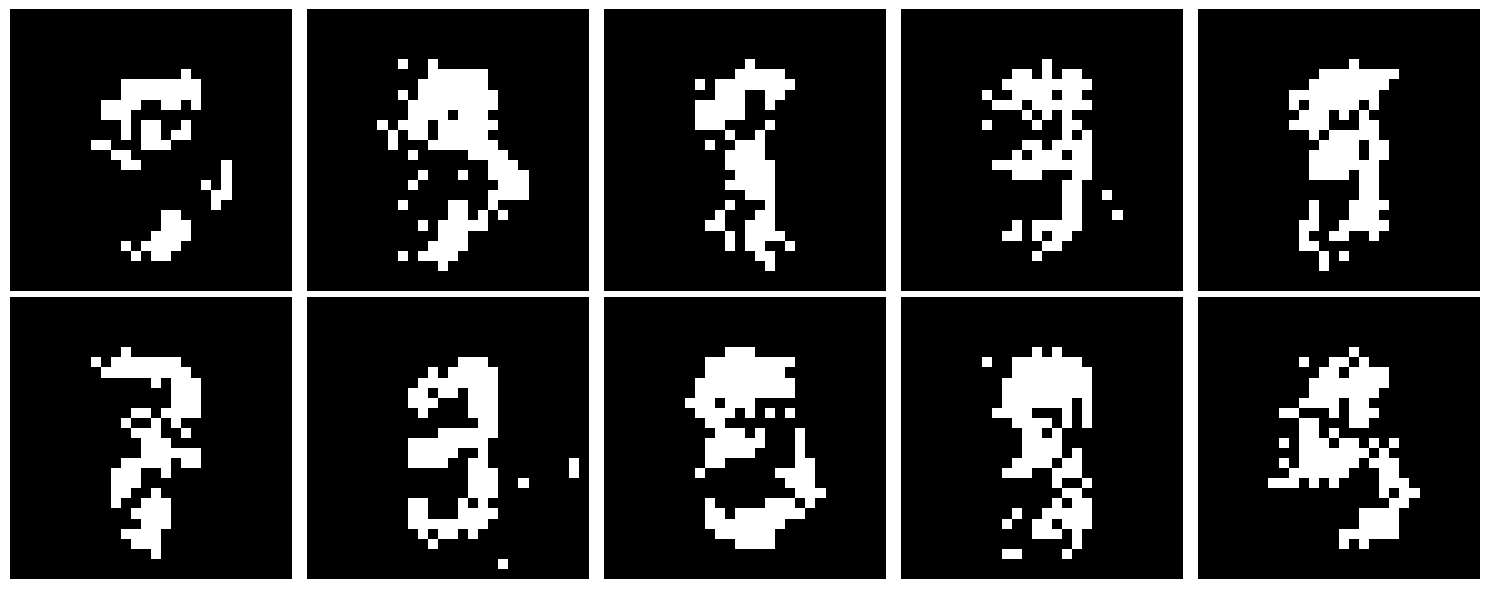

In [66]:
# Create a figure to display the images
fig, axs = plt.subplots(2, 5,figsize=(15, 6))
for i in range(2):
    for j in range(5):
        axs[i,j].imshow(gen[:,i*5+j].reshape(28,28).to('cpu').numpy(), cmap='gray')
        axs[i,j].axis('off')
plt.tight_layout()
plt.show()

In [73]:
Analytic_MNIST_new.to_csv('Analytic_MNIST_new.csv', index = False)

In [74]:
parameters = {'Phi': Phi, 'Theta': Theta}
torch.save(parameters,'Parameters_MNIST_new')

### Plot Analytic

In [67]:
Analytic = Analytic_MNIST_19_batch
Analytic

Phi_Loss_Layer_1  Phi_Loss_Layer_2  Phi_Loss_Layer_3  Phi_Loss_Layer_4  \
0             0.511596          0.136989          0.133915          0.138822   
1             0.280626          0.038555          0.022258          0.050630   
2             0.272191          0.044048          0.040501          0.043784   
3             0.255652          0.043973          0.053069          0.046382   
4             0.233066          0.038921          0.048382          0.044443   
...                ...               ...               ...               ...   
3599          0.057466          0.000557          0.001598          0.000647   
3600          0.051649          0.000632          0.001658          0.000691   
3601          0.056929          0.000807          0.001633          0.000651   
3602          0.054897          0.000996          0.001611          0.000593   
3603          0.050569          0.000558          0.001663          0.000603   

      Phi_Loss_Layer_5  Phi_Loss_Layer_6  Phi_Loss_Layer_7  Phi_Loss_Layer_8  \
0             0.164614          0.205456          0.252014          0.368406   
1             0.065195          0.077587          0.085192          0.104041   
2             0.059391          0.075758          0.058450          0.059848   
3             0.057588          0.048697          0.060946          0.063394   
4             0.052614          0.050173          0.056211          0.049272   
...                ...               ...               ...               ...   
3599          0.000788          0.000825          0.001522          0.003244   
3600          0.000793          0.000806          0.001409          0.003162   
3601          0.000744          0.000768          0.001438          0.003407   
3602          0.000753          0.000787          0.001398          0.002873   
3603          0.000790          0.000882          0.001534          0.002783   

      Phi_Loss_Layer_9  Phi_Loss_Layer_10  ...  Gen_I_Layer_8  Gen_I_Layer_9  \
0             0.495267           0.629982  ...       0.036041       0.096420   
1             0.176528           0.209474  ...       0.022064       0.060707   
2             0.087773           0.209899  ...       0.013388       0.124355   
3             0.093037           0.221028  ...       0.017107       0.113201   
4             0.083646           0.221864  ...       0.012712       0.067858   
...                ...                ...  ...            ...            ...   
3599          0.003714           0.007644  ...      -0.000043       0.000059   
3600          0.003903           0.007157  ...       0.000035       0.000082   
3601          0.003954           0.008481  ...      -0.000012       0.000075   
3602          0.004476           0.007207  ...      -0.000010       0.000079   
3603          0.003844           0.007007  ...      -0.000013       0.000011   

      Gen_I_Layer_10  Gen_I_Layer_11  Gen_I_Layer_12  Gen_I_Layer_13  \
0           0.162323        0.124023        0.021271        0.007385   
1           0.165813        0.189838        0.177666        0.099152   
2           0.176493        0.207287        0.203278        0.127785   
3           0.161028        0.214539        0.213593        0.154709   
4           0.125736        0.212078        0.232147        0.182175   
...              ...             ...             ...             ...   
3599        0.000118        0.000351        0.001564        0.003950   
3600        0.000133        0.000456        0.001684        0.004231   
3601        0.000137        0.000506        0.001869        0.004439   
3602        0.000154        0.000489        0.002021        0.004544   
3603        0.000098        0.000519        0.002356        0.005104   

      Gen_I_Layer_14  Gen_I_Layer_15  Gen_I_Layer_16  Gen_I_Layer_17  
0           0.002251        0.000633        0.000130        0.000023  
1           0.043549        0.012856        0.003204        0.000551  
2           0.066872        0.023331        0

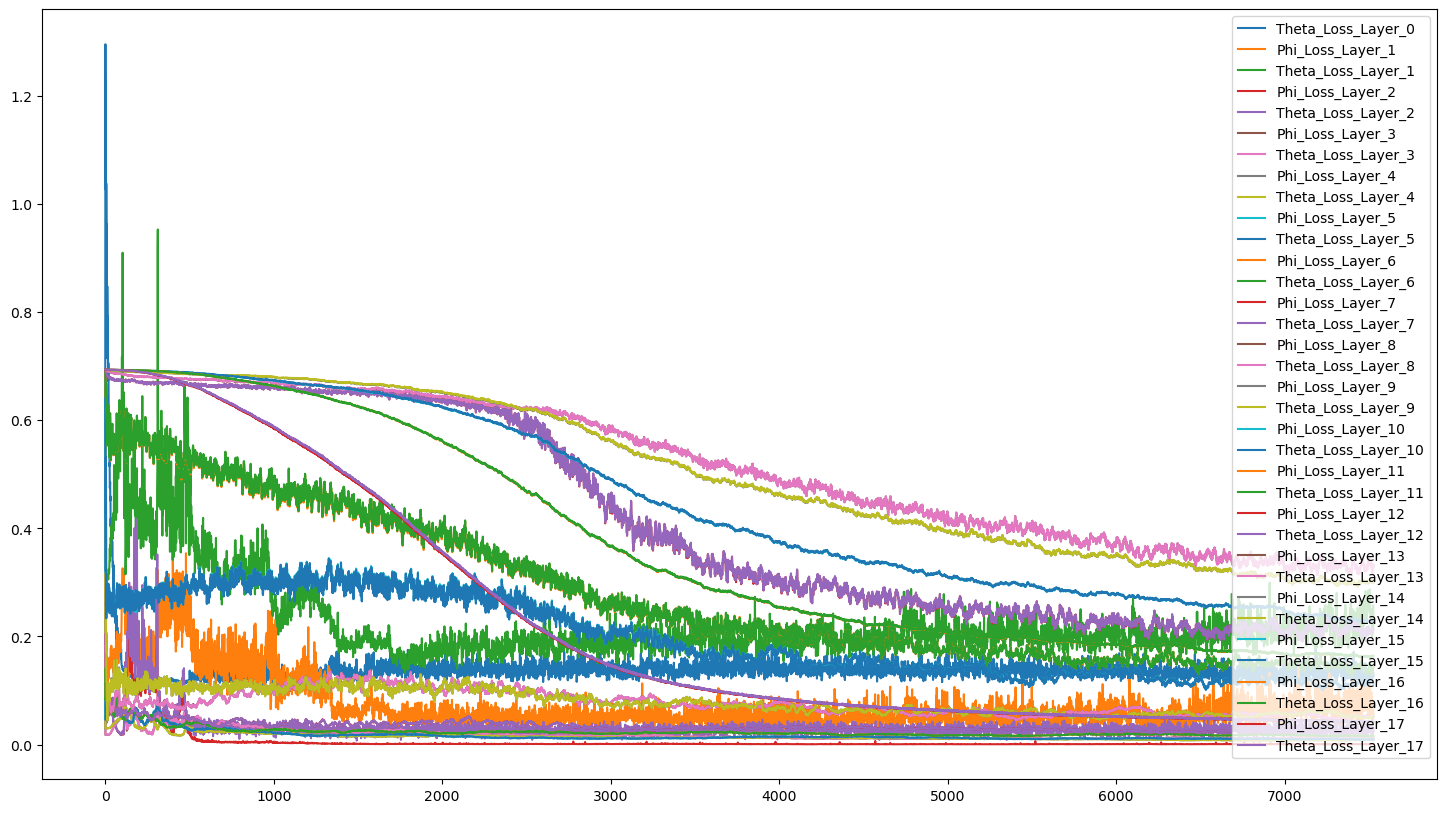

In [46]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic['Theta_Loss_Layer_'+str(0)]),label = 'Theta_Loss_Layer_'+str(0))
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Phi_Loss_Layer_'+str(i)]),label = 'Phi_Loss_Layer_'+str(i))
    ax.plot(np.array(Analytic['Theta_Loss_Layer_'+str(i)]),label = 'Theta_Loss_Layer_'+str(i))
ax.legend()
plt.show()

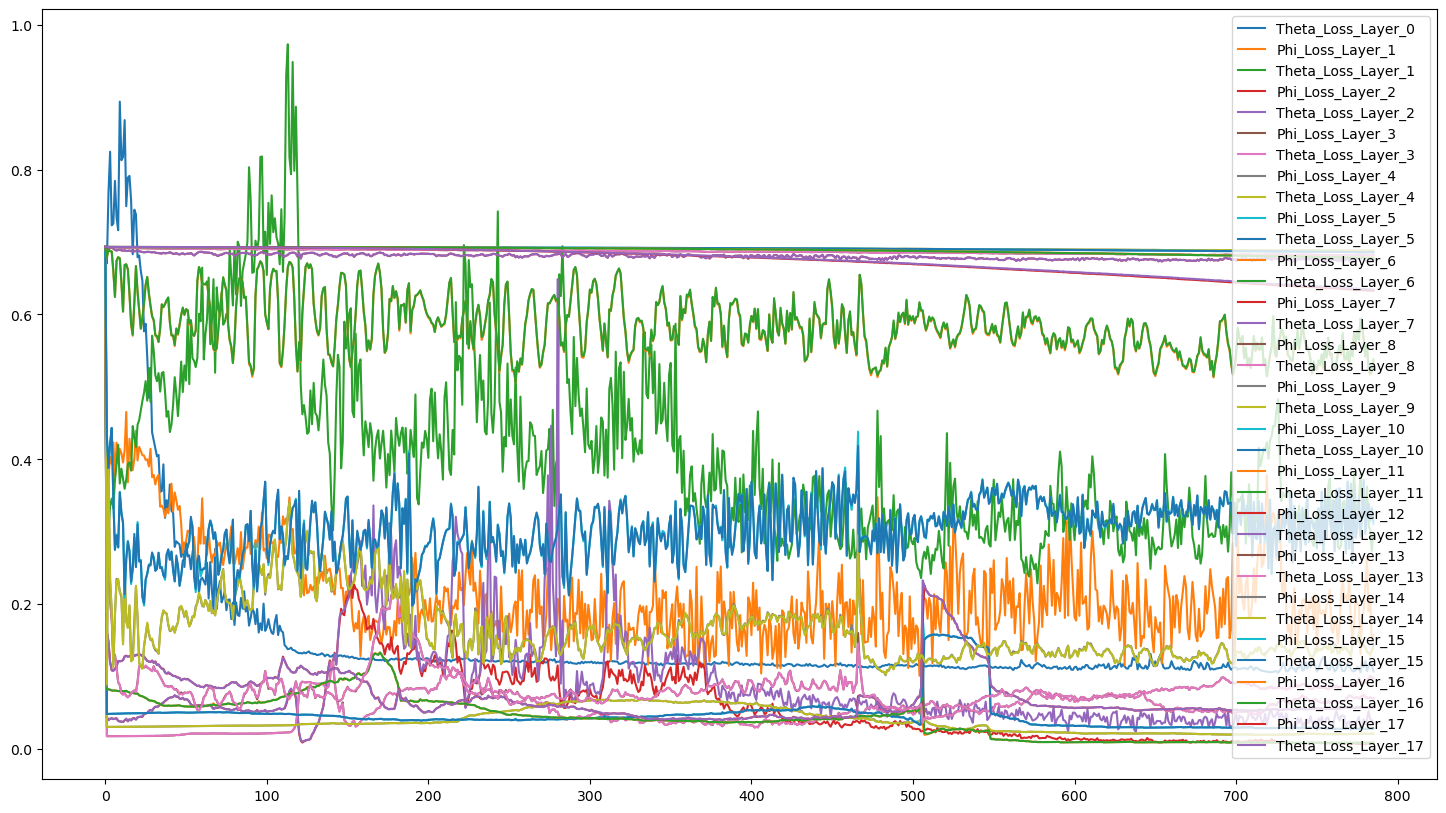

In [58]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic['Theta_Loss_Layer_'+str(0)]),label = 'Theta_Loss_Layer_'+str(0))
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Phi_Loss_Layer_'+str(i)]),label = 'Phi_Loss_Layer_'+str(i))
    ax.plot(np.array(Analytic['Theta_Loss_Layer_'+str(i)]),label = 'Theta_Loss_Layer_'+str(i))
ax.legend()
plt.show()

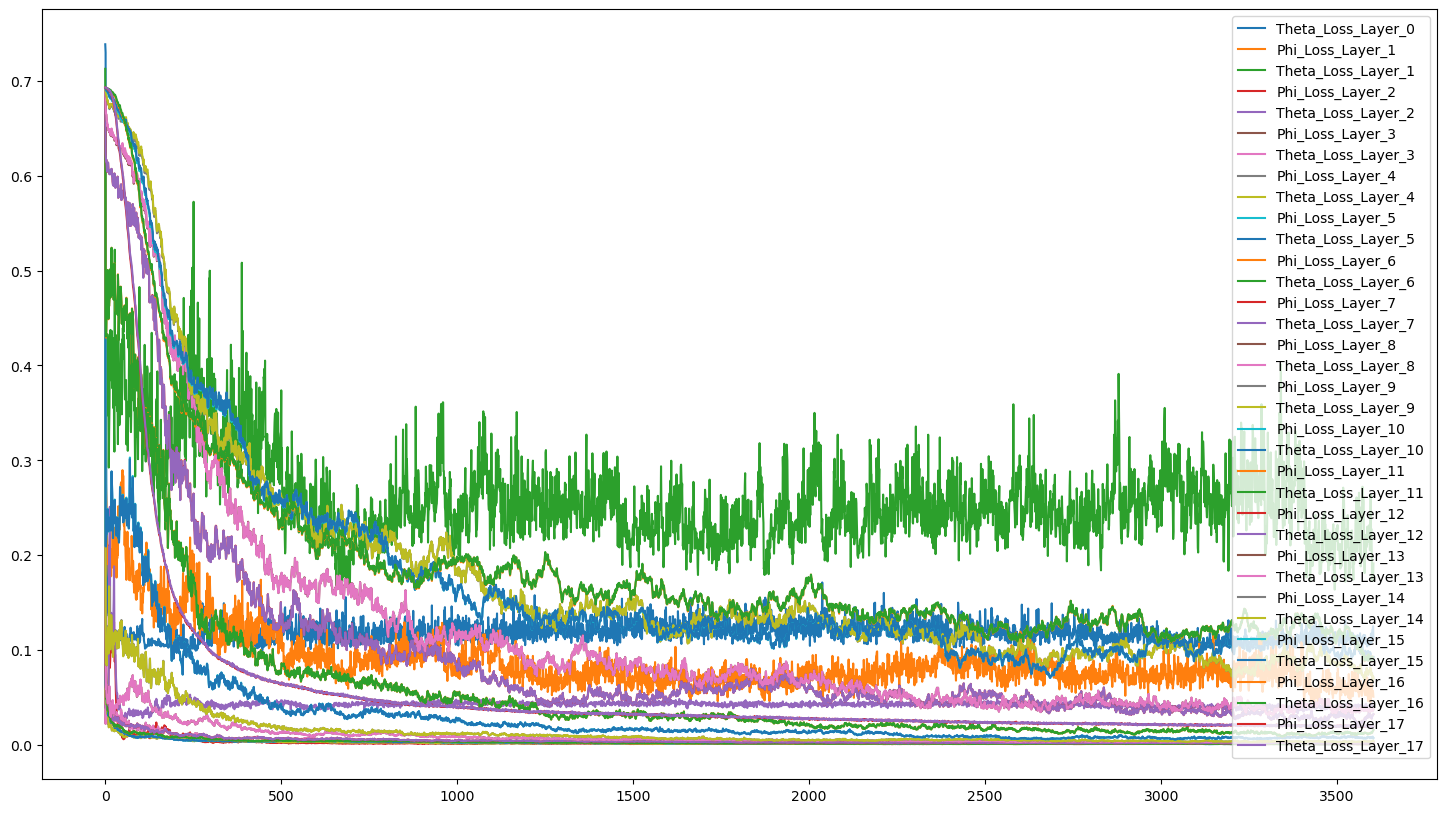

In [68]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic['Theta_Loss_Layer_'+str(0)]),label = 'Theta_Loss_Layer_'+str(0))
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Phi_Loss_Layer_'+str(i)]),label = 'Phi_Loss_Layer_'+str(i))
    ax.plot(np.array(Analytic['Theta_Loss_Layer_'+str(i)]),label = 'Theta_Loss_Layer_'+str(i))
ax.legend()
plt.show()

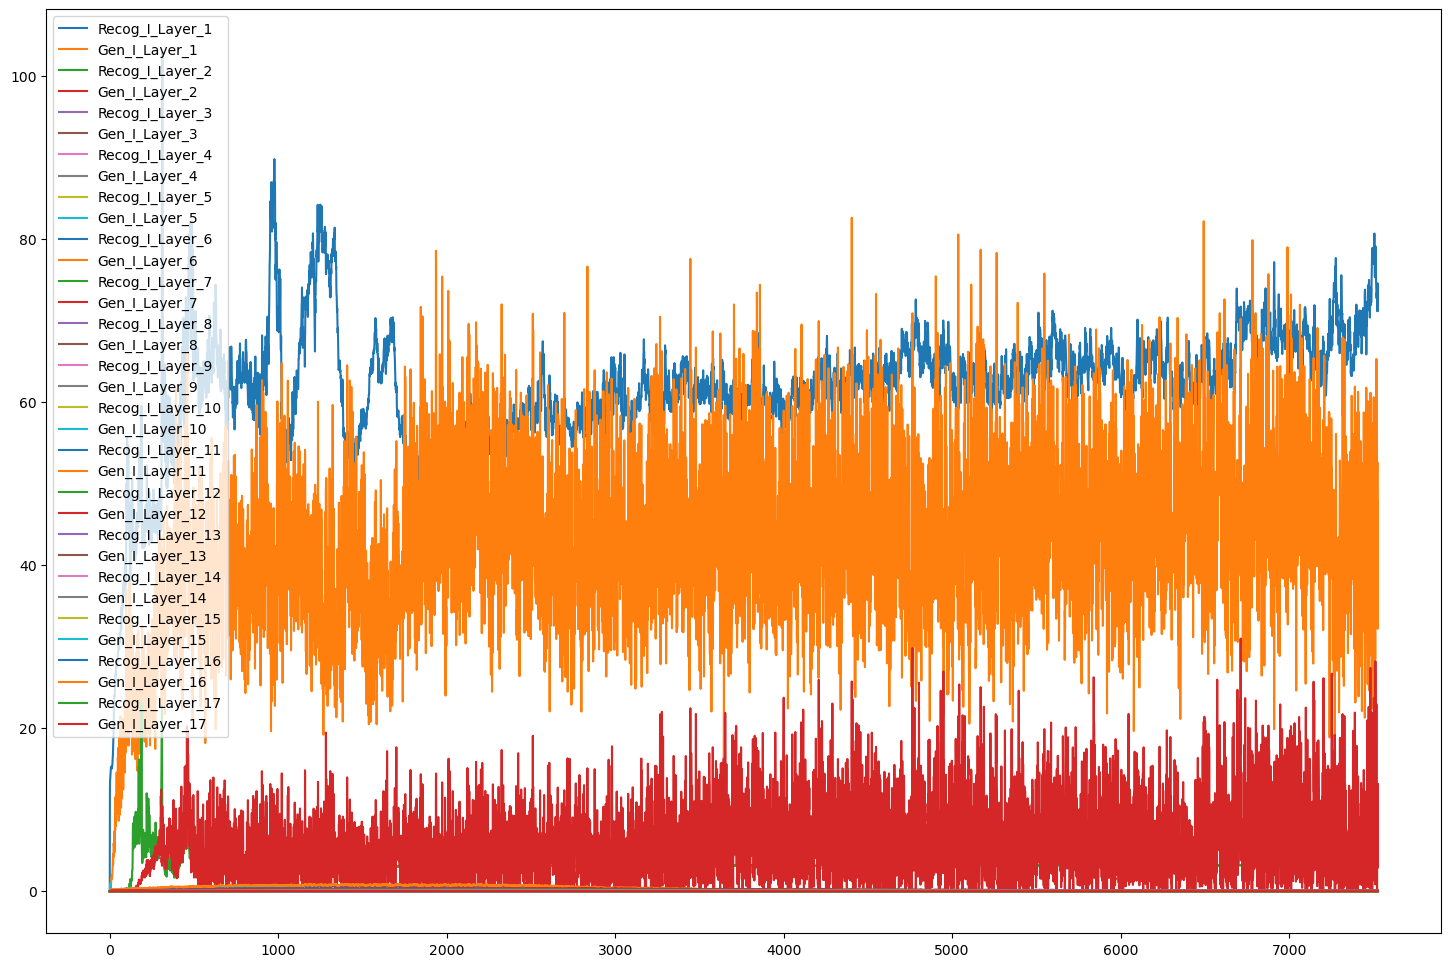

In [47]:
fig, ax = plt.subplots(figsize=(18, 12))
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Recog_I_Layer_'+str(i)]),label = 'Recog_I_Layer_'+str(i))
    ax.plot(np.array(Analytic['Gen_I_Layer_'+str(i)]),label = 'Gen_I_Layer_'+str(i))
ax.legend()
plt.show()

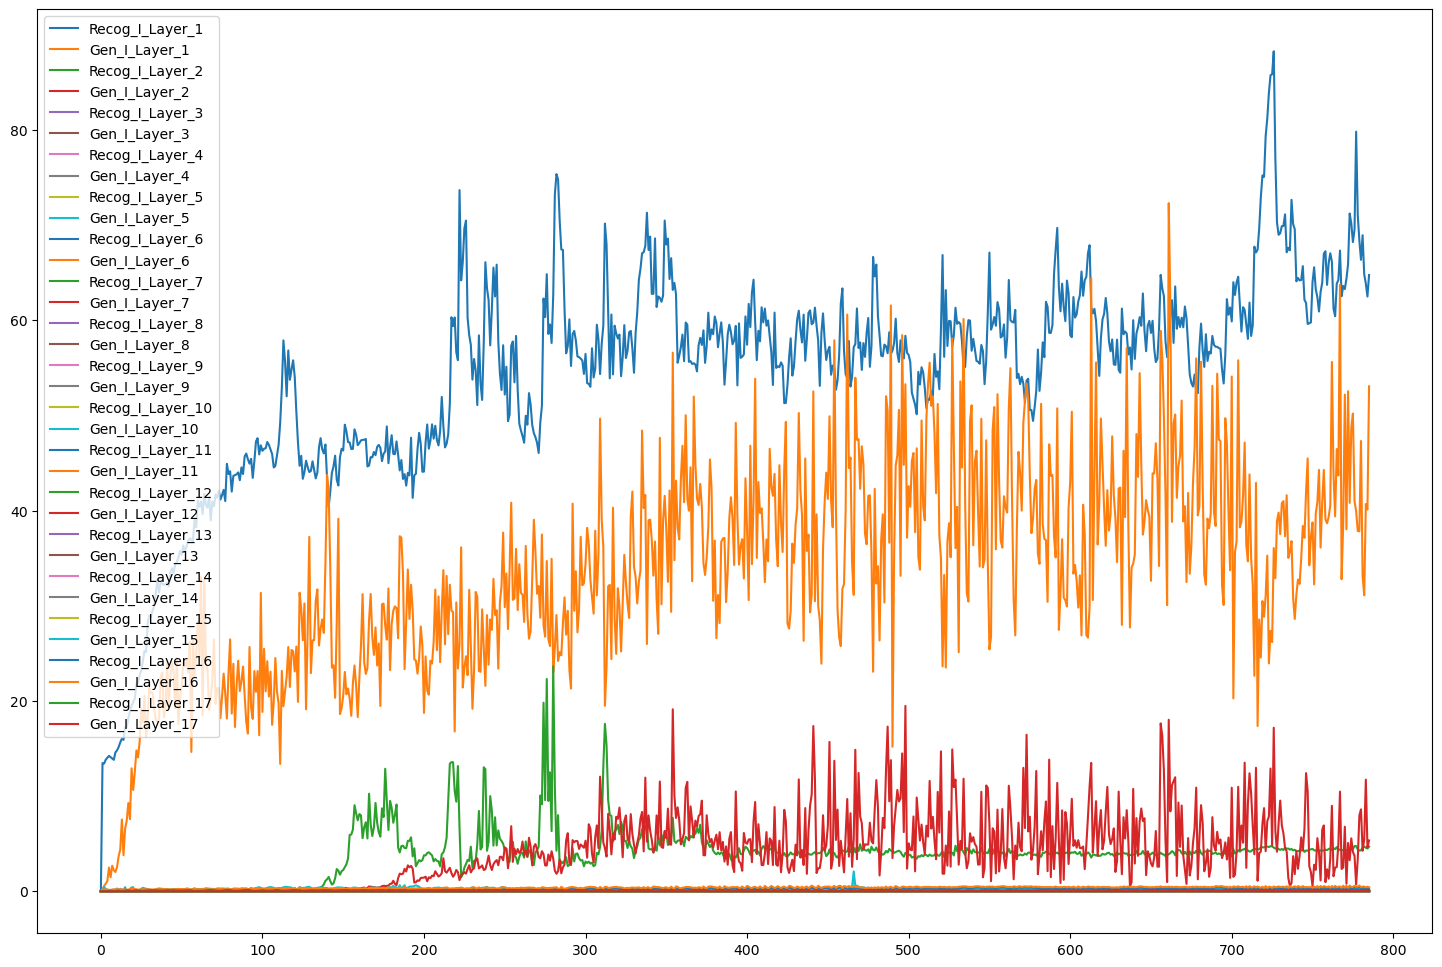

In [59]:
fig, ax = plt.subplots(figsize=(18, 12))
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Recog_I_Layer_'+str(i)]),label = 'Recog_I_Layer_'+str(i))
    ax.plot(np.array(Analytic['Gen_I_Layer_'+str(i)]),label = 'Gen_I_Layer_'+str(i))
ax.legend()
plt.show()

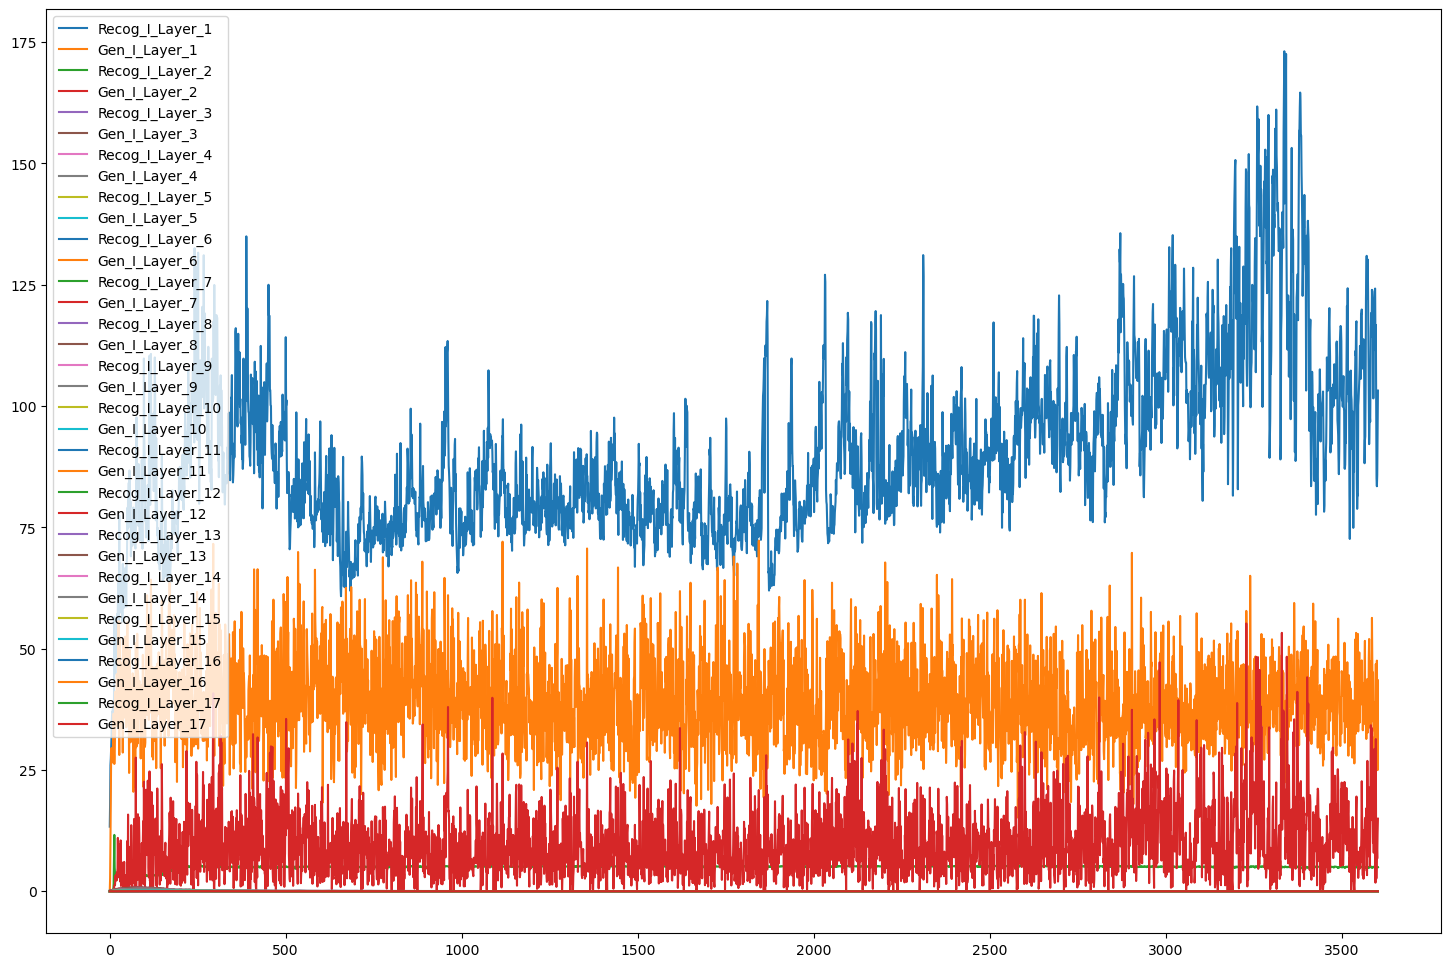

In [69]:
fig, ax = plt.subplots(figsize=(18, 12))
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Recog_I_Layer_'+str(i)]),label = 'Recog_I_Layer_'+str(i))
    ax.plot(np.array(Analytic['Gen_I_Layer_'+str(i)]),label = 'Gen_I_Layer_'+str(i))
ax.legend()
plt.show()

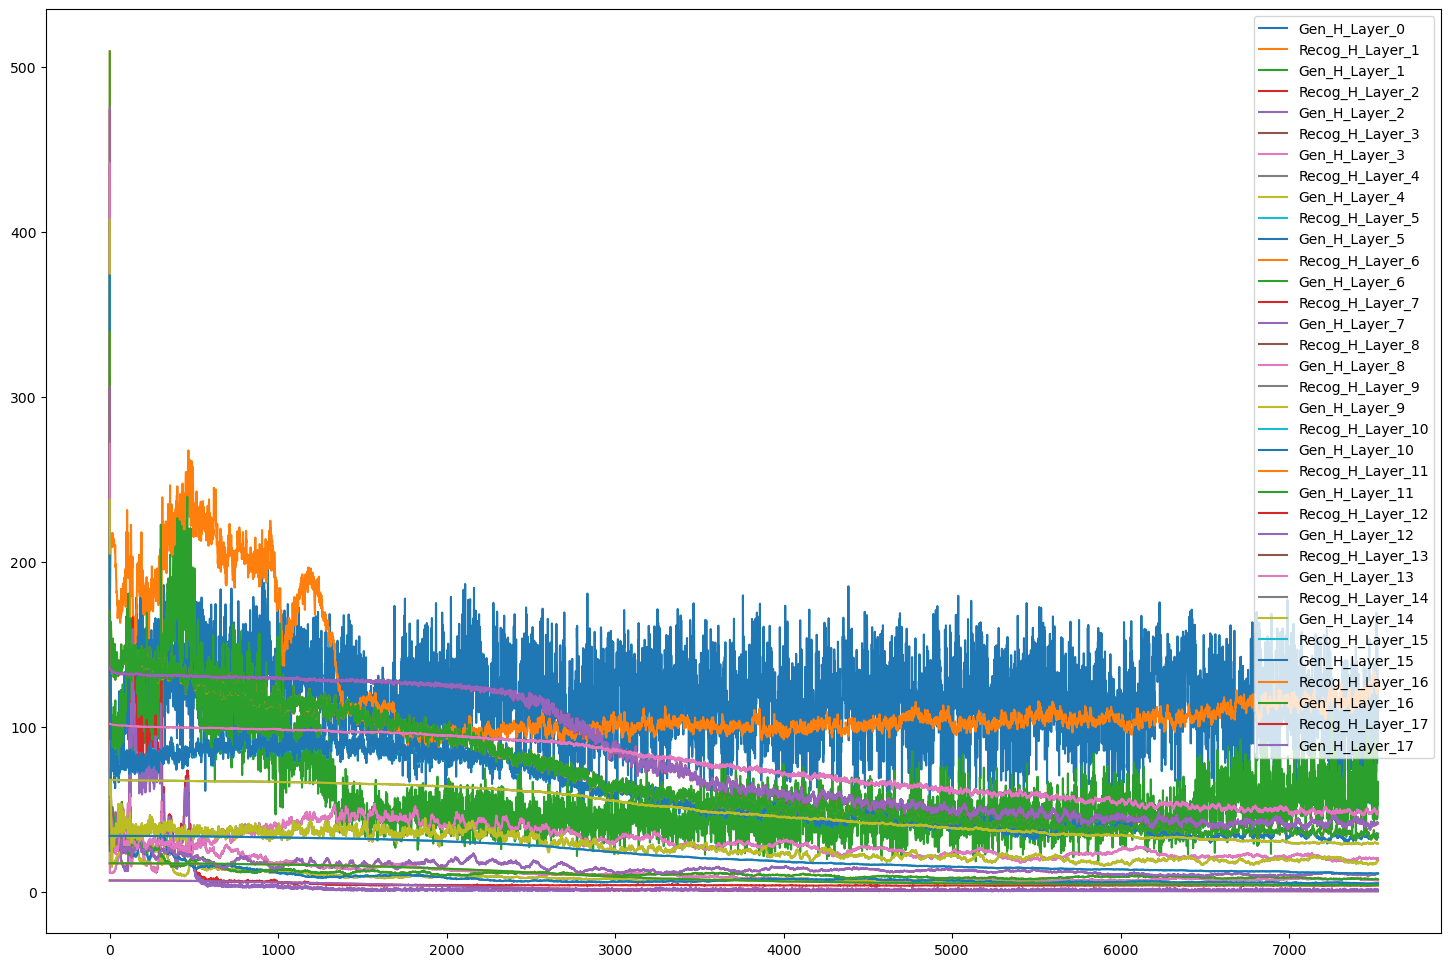

In [48]:
fig, ax = plt.subplots(figsize=(18, 12))
ax.plot(np.array(Analytic['Gen_H_Layer_0']),label = 'Gen_H_Layer_0')
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Recog_H_Layer_'+str(i)]),label = 'Recog_H_Layer_'+str(i))
    ax.plot(np.array(Analytic['Gen_H_Layer_'+str(i)]),label = 'Gen_H_Layer_'+str(i))
ax.legend()
plt.show()

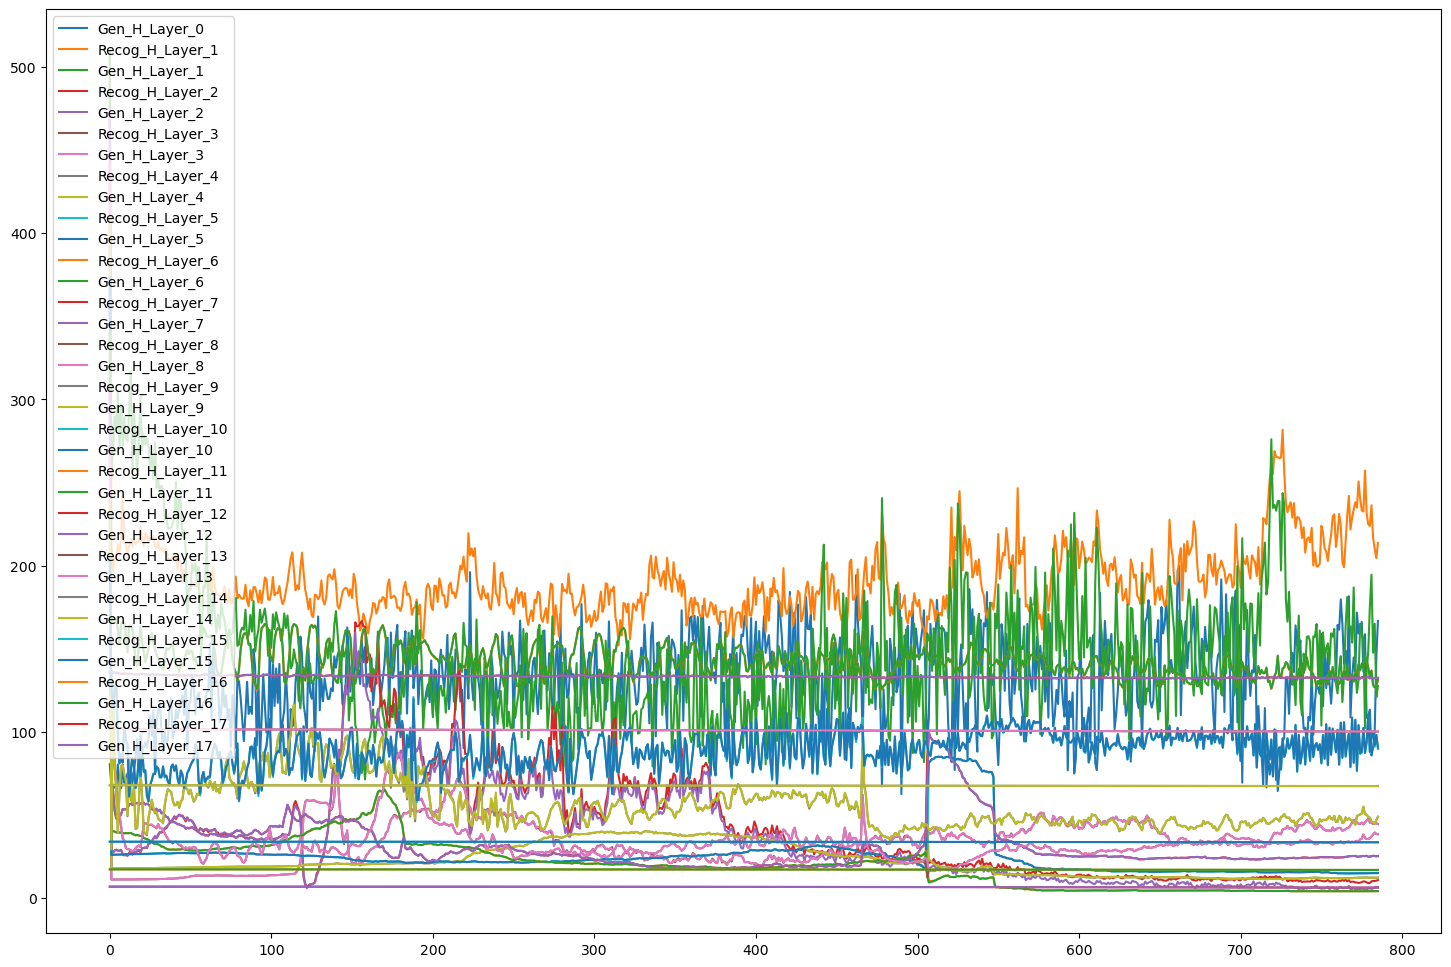

In [60]:
fig, ax = plt.subplots(figsize=(18, 12))
ax.plot(np.array(Analytic['Gen_H_Layer_0']),label = 'Gen_H_Layer_0')
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Recog_H_Layer_'+str(i)]),label = 'Recog_H_Layer_'+str(i))
    ax.plot(np.array(Analytic['Gen_H_Layer_'+str(i)]),label = 'Gen_H_Layer_'+str(i))
ax.legend()
plt.show()

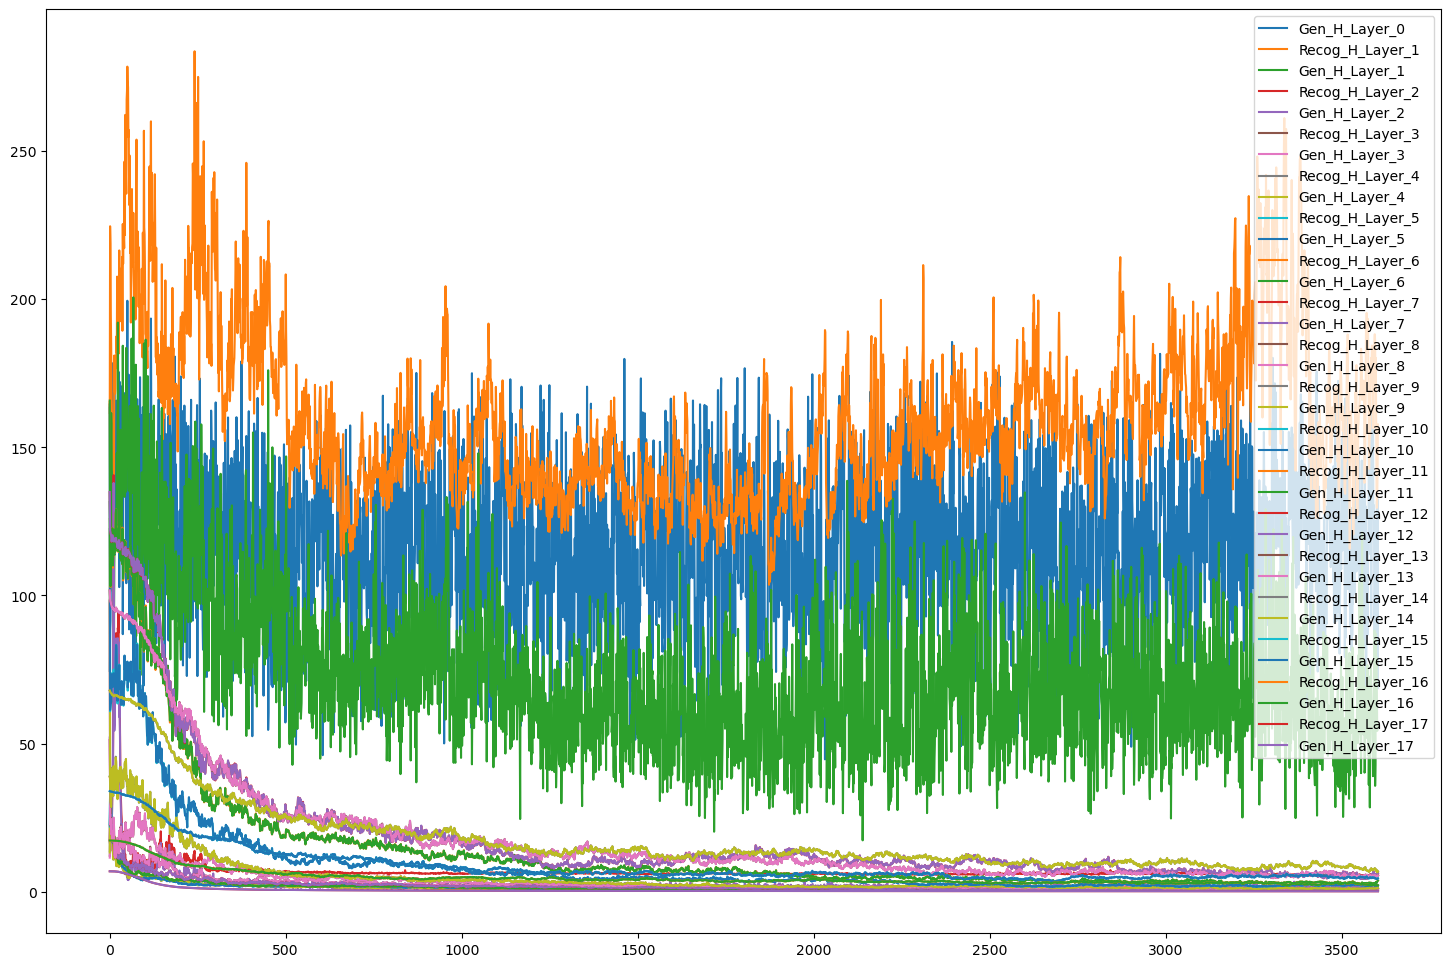

In [70]:
fig, ax = plt.subplots(figsize=(18, 12))
ax.plot(np.array(Analytic['Gen_H_Layer_0']),label = 'Gen_H_Layer_0')
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Recog_H_Layer_'+str(i)]),label = 'Recog_H_Layer_'+str(i))
    ax.plot(np.array(Analytic['Gen_H_Layer_'+str(i)]),label = 'Gen_H_Layer_'+str(i))
ax.legend()
plt.show()

In [50]:
n_dz * np.log(2)

tensor([543.4274, 509.4632, 475.4990, 441.5348, 407.5706, 373.6063, 339.6421,
        305.6779, 271.7137, 237.7495, 203.7853, 169.8211, 135.8568, 101.8926,
         67.9284,  33.9642,  17.3287,   6.9315,   0.6931])

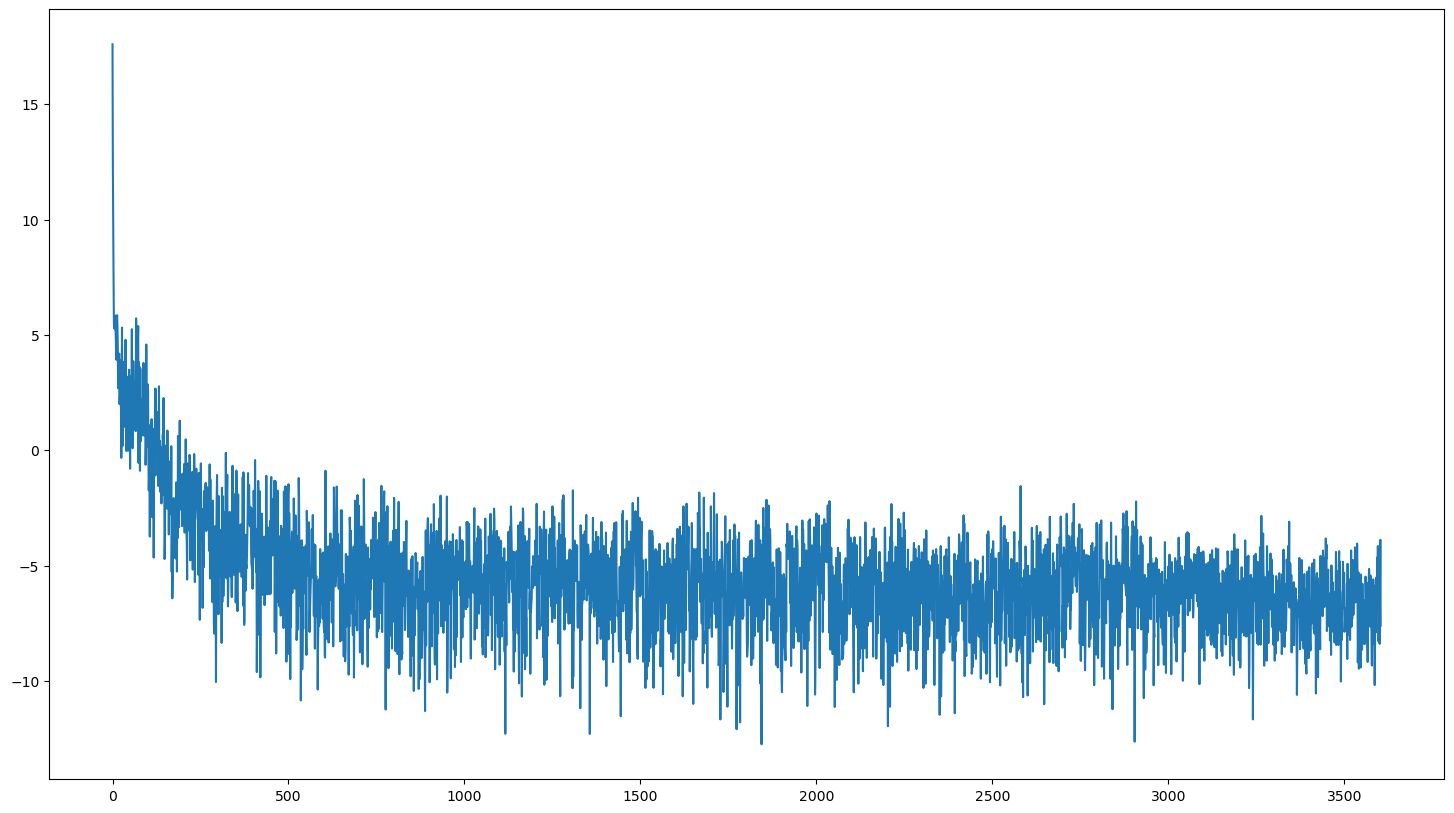

In [71]:
# normalized loss
Loss = 2*(np.array(Analytic['Theta_Loss_Layer_'+str(0)])-(np.array(Analytic['Gen_I_Layer_1'])/structure[i]))
for i in range(1,n_layer-2):
    Loss += np.array(Analytic['Phi_Loss_Layer_'+str(i)]) + np.array(Analytic['Theta_Loss_Layer_'+str(i)]) - \
    (np.array(Analytic['Gen_I_Layer_'+str(i+1)])+np.array(Analytic['Recog_I_Layer_'+str(i)]))/structure[i]
Loss += np.array(Analytic['Phi_Loss_Layer_'+str(n_layer-2)]) + np.array(Analytic['Theta_Loss_Layer_'+str(n_layer-2)]) - \
        np.array(Analytic['Recog_I_Layer_'+str(n_layer-2)])/structure[n_layer-2]
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(Loss)
plt.show()

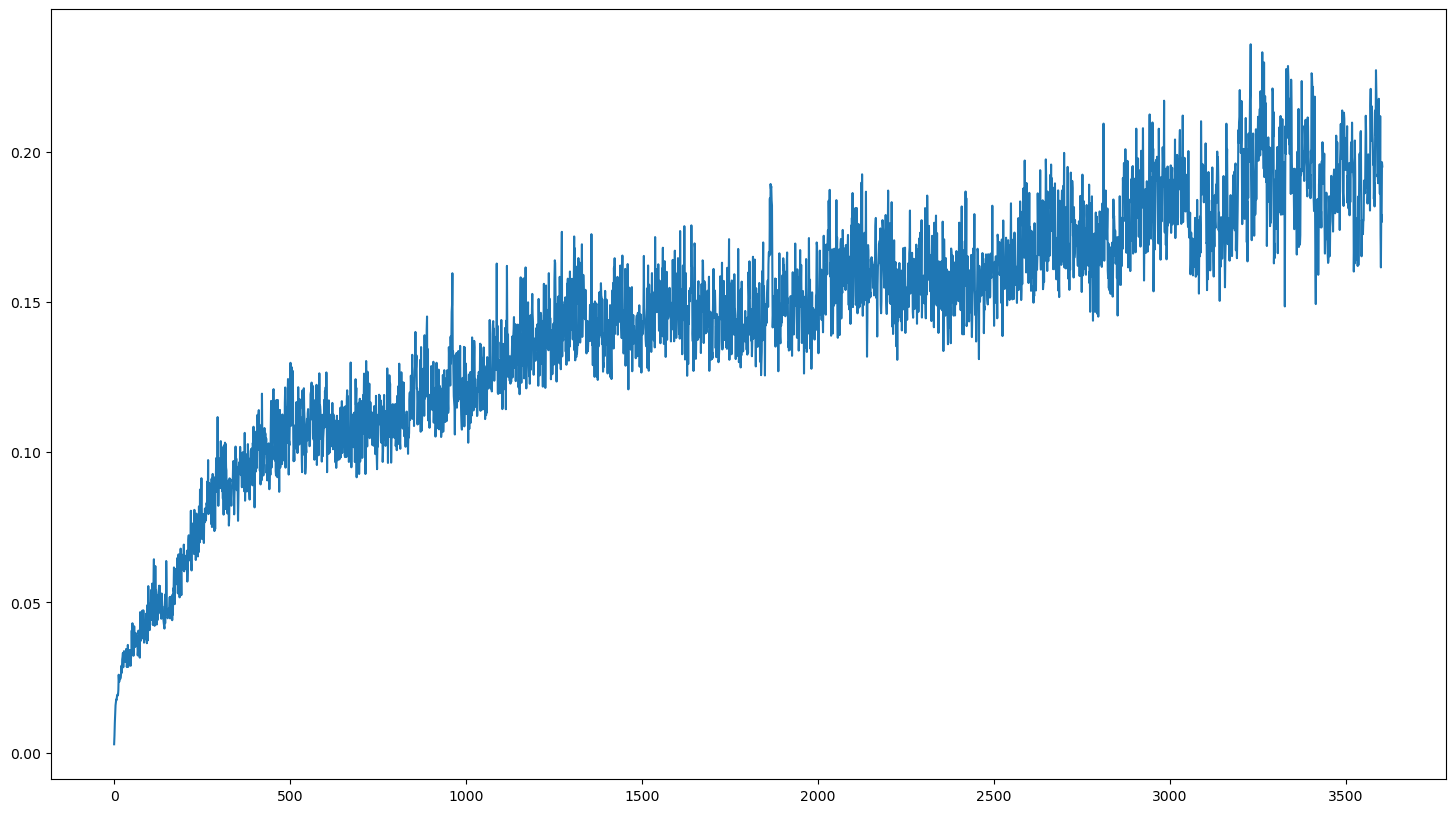

In [72]:
# normalized mutual information
I = np.array(Analytic['Recog_I_Layer_'+str(1)]) + np.array(Analytic['Gen_I_Layer_'+str(1)])
H = np.array(Analytic['Recog_H_Layer_'+str(1)]) + np.array(Analytic['Gen_H_Layer_'+str(0)]) + \
    np.array(Analytic['Gen_H_Layer_'+str(1)]) + np.array(Analytic['Gen_H_Layer_'+str(0)])
for i in range(1,n_layer-2):
    I += np.array(Analytic['Recog_I_Layer_'+str(i+1)]) + np.array(Analytic['Gen_I_Layer_'+str(i+1)])
    H += np.array(Analytic['Recog_H_Layer_'+str(i+1)]) + np.array(Analytic['Recog_H_Layer_'+str(i)]) + \
    np.array(Analytic['Gen_H_Layer_'+str(i+1)]) + np.array(Analytic['Gen_H_Layer_'+str(i)])
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(I/H)
plt.show()